# Image Generation With GANs

Aim of this project is to generate image on the basis of real image and we can use that image to create Anime characters which we use in animation production.
Game development and animation production are expensive and hire many production artists for relatively routine tasks. GAN can auto-generate and colorize Anime characters.

Implementation of Deep Convolutional Generative Adversarial Networks using pytorch on CIFAR-10 Image dataset.

## Data Description

he CIFAR-10 dataset consists of 60000 32x32 colour images,There are 50000 training images and 10000 test images. 
but we have used only training image because there is no need of test image in our Deep Convolutional Generative Adversarial Networks

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images. And I have used 64 batch size and trained Generative Adverserial Netwroks(GANs) upto 15 epochs

## Data Size

178 mb

## Requirements

1. Pytorch 
2. Python 3

In [1]:
# Deep Convolutional GANs

# Importing the libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting some hyperparameters
batchSize = 64 # We set the size of the batch.
imageSize = 64 # We set the size of the generated images (64x64).

# Creating the transformations
transform = transforms.Compose([transforms.Scale(imageSize), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]) # We create a list of transformations (scaling, tensor conversion, normalization) to apply to the input images.

# Loading the dataset
dataset = dset.CIFAR10(root = './Data2', download = True, transform = transform) # We download the training set in the ./data folder and we apply the previous transformations on each image.
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 2) # We use dataLoader to get the images of the training set batch by batch.


In [4]:
# size of the dataset
print(len(dataset))

# created the batch of our dataset to make it easy while training our brain of Descriminator
print(len(dataloader))

50000
782


In [5]:
# Defining the weights_init function that takes as input a neural network m and that will initialize all its weights.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# The Generator Network 

In [6]:
# Defining the generator

class G(nn.Module): # We introduce a class to define the generator.

    def __init__(self): # We introduce the __init__() function that will define the architecture of the generator.
        super(G, self).__init__() # We inherit from the nn.Module tools.
        self.main = nn.Sequential( # We create a meta module of a neural network that will contain a sequence of modules (convolutions, full connections, etc.).
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias = False), # We start with an inversed convolution.
            nn.BatchNorm2d(512), # We normalize all the features along the dimension of the batch.
            nn.ReLU(True), # We apply a ReLU rectification to break the linearity.
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False), # We add another inversed convolution.
            nn.BatchNorm2d(256), # We normalize again.
            nn.ReLU(True), # We apply another ReLU.
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False), # We add another inversed convolution.
            nn.BatchNorm2d(128), # We normalize again.
            nn.ReLU(True), # We apply another ReLU.
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False), # We add another inversed convolution.
            nn.BatchNorm2d(64), # We normalize again.
            nn.ReLU(True), # We apply another ReLU.
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False), # We add another inversed convolution.
            nn.Tanh() # We apply a Tanh rectification to break the linearity and stay between -1 and +1.
        )

    def forward(self, input): # We define the forward function that takes as argument an input that will be fed to the neural network, and that will return the output containing the generated images.
        output = self.main(input) # We forward propagate the signal through the whole neural network of the generator defined by self.main.
        return output # We return the output containing the generated images.

# Creating the generator
netG = G() # We create the generator object.
netG.apply(weights_init) # We initialize all the weights of its neural network.


G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

# The Descriminator Network 

In [7]:
# Defining the discriminator

class D(nn.Module): # We introduce a class to define the discriminator.

    def __init__(self): # We introduce the __init__() function that will define the architecture of the discriminator.
        super(D, self).__init__() # We inherit from the nn.Module tools.
        self.main = nn.Sequential( # We create a meta module of a neural network that will contain a sequence of modules (convolutions, full connections, etc.).
            nn.Conv2d(3, 64, 4, 2, 1, bias = False), # We start with a convolution.
            nn.LeakyReLU(0.2, inplace = True), # We apply a LeakyReLU.
            nn.Conv2d(64, 128, 4, 2, 1, bias = False), # We add another convolution.
            nn.BatchNorm2d(128), # We normalize all the features along the dimension of the batch.
            nn.LeakyReLU(0.2, inplace = True), # We apply another LeakyReLU.
            nn.Conv2d(128, 256, 4, 2, 1, bias = False), # We add another convolution.
            nn.BatchNorm2d(256), # We normalize again.
            nn.LeakyReLU(0.2, inplace = True), # We apply another LeakyReLU.
            nn.Conv2d(256, 512, 4, 2, 1, bias = False), # We add another convolution.
            nn.BatchNorm2d(512), # We normalize again.
            nn.LeakyReLU(0.2, inplace = True), # We apply another LeakyReLU.
            nn.Conv2d(512, 1, 4, 1, 0, bias = False), # We add another convolution.
            nn.Sigmoid() # We apply a Sigmoid rectification to break the linearity and stay between 0 and 1.
        )

    def forward(self, input): # We define the forward function that takes as argument an input that will be fed to the neural network, and that will return the output which will be a value between 0 and 1.
        output = self.main(input) # We forward propagate the signal through the whole neural network of the discriminator defined by self.main.
        return output.view(-1) # We return the output which will be a value between 0 and 1.

# Creating the discriminator
netD = D() # We create the discriminator object.
netD.apply(weights_init) # We initialize all the weights of its neural network.

D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [8]:
# Training the DCGANs

criterion = nn.BCELoss() # We create a criterion object that will measure the error between the prediction and the target.
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999)) # We create the optimizer object of the discriminator.
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999)) # We create the optimizer object of the generator.

In [11]:
for epoch in range(15): # We iterate over 15 epochs.

    for i, data in enumerate(dataloader, 0): # We iterate over the images of the dataset.
        
        # 1st Step: Updating the weights of the neural network of the discriminator

        netD.zero_grad() # We initialize to 0 the gradients of the discriminator with respect to the weights.
        
        # Training the discriminator with a real image of the dataset
        real, _ = data # We get a real image of the dataset which will be used to train the discriminator.
        input = Variable(real) # We wrap it in a variable.
        target = Variable(torch.ones(input.size()[0])) # We get the target.
        output = netD(input) # We forward propagate this real image into the neural network of the discriminator to get the prediction (a value between 0 and 1).
        errD_real = criterion(output, target) # We compute the loss between the predictions (output) and the target (equal to 1).
        
        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1)) # We make a random input vector (noise) of the generator.
        fake = netG(noise) # We forward propagate this random input vector into the neural network of the generator to get some fake generated images.
        target = Variable(torch.zeros(input.size()[0])) # We get the target.
        output = netD(fake.detach()) # We forward propagate the fake generated images into the neural network of the discriminator to get the prediction (a value between 0 and 1).
        errD_fake = criterion(output, target) # We compute the loss between the prediction (output) and the target (equal to 0).

        # Backpropagating the total error
        errD = errD_real + errD_fake # We compute the total error of the discriminator.
        errD.backward() # We backpropagate the loss error by computing the gradients of the total error with respect to the weights of the discriminator.
        optimizerD.step() # We apply the optimizer to update the weights according to how much they are responsible for the loss error of the discriminator.

        # 2nd Step: Updating the weights of the neural network of the generator

        netG.zero_grad() # We initialize to 0 the gradients of the generator with respect to the weights.
        target = Variable(torch.ones(input.size()[0])) # We get the target.
        output = netD(fake) # We forward propagate the fake generated images into the neural network of the discriminator to get the prediction (a value between 0 and 1).
        errG = criterion(output, target) # We compute the loss between the prediction (output between 0 and 1) and the target (equal to 1).
        errG.backward() # We backpropagate the loss error by computing the gradients of the total error with respect to the weights of the generator.
        optimizerG.step() # We apply the optimizer to update the weights according to how much they are responsible for the loss error of the generator.
        
        # 3rd Step: Printing the losses and saving the real images and the generated images of the minibatch every 100 steps

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, 15, i, len(dataloader), errD.item(), errG.item())) # We print les losses of the discriminator (Loss_D) and the generator (Loss_G).
        if i % 100 == 0: # Every 100 steps:
            vutils.save_image(real, '%s/real_samples.png' % "./results", normalize = True) # We save the real images of the minibatch.
            fake = netG(noise) # We get our fake generated images.
            vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./results", epoch), normalize = True) # We also save the fake generated images of the minibatch.

[0/15][0/782] Loss_D: 0.4535 Loss_G: 6.4809
[0/15][1/782] Loss_D: 0.3361 Loss_G: 4.1489
[0/15][2/782] Loss_D: 1.4453 Loss_G: 7.2102
[0/15][3/782] Loss_D: 0.6686 Loss_G: 7.1500
[0/15][4/782] Loss_D: 0.7478 Loss_G: 6.3952
[0/15][5/782] Loss_D: 0.7592 Loss_G: 7.3268
[0/15][6/782] Loss_D: 0.7069 Loss_G: 7.5810
[0/15][7/782] Loss_D: 0.6320 Loss_G: 7.6980
[0/15][8/782] Loss_D: 0.5494 Loss_G: 8.8557
[0/15][9/782] Loss_D: 0.3701 Loss_G: 7.6450
[0/15][10/782] Loss_D: 0.6845 Loss_G: 9.9498
[0/15][11/782] Loss_D: 0.4568 Loss_G: 7.5204
[0/15][12/782] Loss_D: 0.8856 Loss_G: 12.7424
[0/15][13/782] Loss_D: 0.2145 Loss_G: 10.8960
[0/15][14/782] Loss_D: 0.2580 Loss_G: 6.8871
[0/15][15/782] Loss_D: 1.2967 Loss_G: 16.2439
[0/15][16/782] Loss_D: 0.5971 Loss_G: 15.9037
[0/15][17/782] Loss_D: 0.3384 Loss_G: 10.6516
[0/15][18/782] Loss_D: 0.2800 Loss_G: 8.5850
[0/15][19/782] Loss_D: 0.6332 Loss_G: 15.6833
[0/15][20/782] Loss_D: 0.1774 Loss_G: 14.8058
[0/15][21/782] Loss_D: 0.2334 Loss_G: 8.7897
[0/15][22/782

[0/15][180/782] Loss_D: 0.2409 Loss_G: 9.2314
[0/15][181/782] Loss_D: 0.0534 Loss_G: 5.8226
[0/15][182/782] Loss_D: 0.4769 Loss_G: 11.0739
[0/15][183/782] Loss_D: 0.2773 Loss_G: 9.7504
[0/15][184/782] Loss_D: 0.0888 Loss_G: 6.6865
[0/15][185/782] Loss_D: 0.1510 Loss_G: 6.3827
[0/15][186/782] Loss_D: 0.1921 Loss_G: 7.7112
[0/15][187/782] Loss_D: 0.2445 Loss_G: 5.2721
[0/15][188/782] Loss_D: 0.3245 Loss_G: 11.0759
[0/15][189/782] Loss_D: 0.2122 Loss_G: 9.9828
[0/15][190/782] Loss_D: 0.0420 Loss_G: 6.5048
[0/15][191/782] Loss_D: 0.2024 Loss_G: 8.2851
[0/15][192/782] Loss_D: 0.0774 Loss_G: 7.3725
[0/15][193/782] Loss_D: 0.2681 Loss_G: 5.1826
[0/15][194/782] Loss_D: 0.4144 Loss_G: 11.4300
[0/15][195/782] Loss_D: 0.0787 Loss_G: 12.0985
[0/15][196/782] Loss_D: 0.4124 Loss_G: 8.3672
[0/15][197/782] Loss_D: 0.1237 Loss_G: 4.0548
[0/15][198/782] Loss_D: 1.1381 Loss_G: 19.2501
[0/15][199/782] Loss_D: 1.7926 Loss_G: 19.8086
[0/15][200/782] Loss_D: 0.3675 Loss_G: 16.4317
[0/15][201/782] Loss_D: 0.0

[0/15][358/782] Loss_D: 1.3928 Loss_G: 2.8431
[0/15][359/782] Loss_D: 0.5419 Loss_G: 4.1594
[0/15][360/782] Loss_D: 0.2764 Loss_G: 4.2380
[0/15][361/782] Loss_D: 0.2763 Loss_G: 3.2795
[0/15][362/782] Loss_D: 0.4024 Loss_G: 4.8151
[0/15][363/782] Loss_D: 0.4433 Loss_G: 3.4565
[0/15][364/782] Loss_D: 0.3418 Loss_G: 3.7713
[0/15][365/782] Loss_D: 0.3733 Loss_G: 4.8390
[0/15][366/782] Loss_D: 0.3764 Loss_G: 3.3982
[0/15][367/782] Loss_D: 0.5701 Loss_G: 6.8738
[0/15][368/782] Loss_D: 0.5307 Loss_G: 4.1351
[0/15][369/782] Loss_D: 0.5335 Loss_G: 2.5982
[0/15][370/782] Loss_D: 0.9436 Loss_G: 6.9177
[0/15][371/782] Loss_D: 1.3356 Loss_G: 1.1589
[0/15][372/782] Loss_D: 1.6773 Loss_G: 7.2339
[0/15][373/782] Loss_D: 1.5840 Loss_G: 1.3808
[0/15][374/782] Loss_D: 1.2319 Loss_G: 5.5955
[0/15][375/782] Loss_D: 1.3801 Loss_G: 2.4273
[0/15][376/782] Loss_D: 0.9173 Loss_G: 4.3043
[0/15][377/782] Loss_D: 0.4139 Loss_G: 4.4059
[0/15][378/782] Loss_D: 0.4830 Loss_G: 3.2036
[0/15][379/782] Loss_D: 0.8578 Los

[0/15][537/782] Loss_D: 0.4776 Loss_G: 3.6787
[0/15][538/782] Loss_D: 0.4757 Loss_G: 6.4360
[0/15][539/782] Loss_D: 0.1809 Loss_G: 5.5935
[0/15][540/782] Loss_D: 0.6627 Loss_G: 2.2683
[0/15][541/782] Loss_D: 1.6980 Loss_G: 7.8099
[0/15][542/782] Loss_D: 0.8889 Loss_G: 6.4560
[0/15][543/782] Loss_D: 0.2485 Loss_G: 2.8743
[0/15][544/782] Loss_D: 0.7786 Loss_G: 6.9219
[0/15][545/782] Loss_D: 1.3605 Loss_G: 2.8621
[0/15][546/782] Loss_D: 0.6610 Loss_G: 5.9176
[0/15][547/782] Loss_D: 0.3234 Loss_G: 5.3596
[0/15][548/782] Loss_D: 0.2116 Loss_G: 4.0667
[0/15][549/782] Loss_D: 0.4089 Loss_G: 4.9455
[0/15][550/782] Loss_D: 0.6324 Loss_G: 3.7754
[0/15][551/782] Loss_D: 0.4650 Loss_G: 5.1651
[0/15][552/782] Loss_D: 0.3914 Loss_G: 4.4041
[0/15][553/782] Loss_D: 0.4072 Loss_G: 3.3282
[0/15][554/782] Loss_D: 0.7880 Loss_G: 7.8942
[0/15][555/782] Loss_D: 2.0607 Loss_G: 1.8577
[0/15][556/782] Loss_D: 0.8522 Loss_G: 5.6830
[0/15][557/782] Loss_D: 0.2435 Loss_G: 5.6709
[0/15][558/782] Loss_D: 0.1508 Los

[0/15][715/782] Loss_D: 1.4799 Loss_G: 9.5811
[0/15][716/782] Loss_D: 3.3584 Loss_G: 3.8474
[0/15][717/782] Loss_D: 0.2150 Loss_G: 2.3216
[0/15][718/782] Loss_D: 0.6825 Loss_G: 6.1657
[0/15][719/782] Loss_D: 0.3892 Loss_G: 4.8091
[0/15][720/782] Loss_D: 0.2923 Loss_G: 3.1222
[0/15][721/782] Loss_D: 0.3601 Loss_G: 4.7987
[0/15][722/782] Loss_D: 0.4263 Loss_G: 3.7962
[0/15][723/782] Loss_D: 0.3152 Loss_G: 3.9659
[0/15][724/782] Loss_D: 0.3680 Loss_G: 5.7035
[0/15][725/782] Loss_D: 0.4562 Loss_G: 3.0761
[0/15][726/782] Loss_D: 0.3505 Loss_G: 4.1157
[0/15][727/782] Loss_D: 0.3179 Loss_G: 6.0438
[0/15][728/782] Loss_D: 0.6253 Loss_G: 2.7226
[0/15][729/782] Loss_D: 0.5156 Loss_G: 4.8740
[0/15][730/782] Loss_D: 0.6348 Loss_G: 2.5835
[0/15][731/782] Loss_D: 0.6029 Loss_G: 6.1525
[0/15][732/782] Loss_D: 0.4532 Loss_G: 4.6929
[0/15][733/782] Loss_D: 0.3478 Loss_G: 3.8714
[0/15][734/782] Loss_D: 0.3096 Loss_G: 5.2048
[0/15][735/782] Loss_D: 0.4231 Loss_G: 3.0661
[0/15][736/782] Loss_D: 0.4163 Los

[1/15][114/782] Loss_D: 0.3407 Loss_G: 4.5635
[1/15][115/782] Loss_D: 0.4703 Loss_G: 3.1014
[1/15][116/782] Loss_D: 0.7738 Loss_G: 3.8633
[1/15][117/782] Loss_D: 0.5068 Loss_G: 3.3262
[1/15][118/782] Loss_D: 0.6879 Loss_G: 5.0182
[1/15][119/782] Loss_D: 1.0268 Loss_G: 1.6659
[1/15][120/782] Loss_D: 1.0945 Loss_G: 6.6062
[1/15][121/782] Loss_D: 1.1727 Loss_G: 2.2739
[1/15][122/782] Loss_D: 0.4201 Loss_G: 2.8778
[1/15][123/782] Loss_D: 0.6187 Loss_G: 4.2817
[1/15][124/782] Loss_D: 0.7085 Loss_G: 2.1611
[1/15][125/782] Loss_D: 0.5996 Loss_G: 4.2925
[1/15][126/782] Loss_D: 0.2922 Loss_G: 4.0203
[1/15][127/782] Loss_D: 0.2662 Loss_G: 3.2765
[1/15][128/782] Loss_D: 0.6704 Loss_G: 2.9610
[1/15][129/782] Loss_D: 0.7560 Loss_G: 4.0247
[1/15][130/782] Loss_D: 0.8103 Loss_G: 2.3906
[1/15][131/782] Loss_D: 0.5320 Loss_G: 3.3675
[1/15][132/782] Loss_D: 0.7119 Loss_G: 2.2875
[1/15][133/782] Loss_D: 0.5026 Loss_G: 5.3476
[1/15][134/782] Loss_D: 0.3338 Loss_G: 4.4458
[1/15][135/782] Loss_D: 0.3233 Los

[1/15][293/782] Loss_D: 0.4115 Loss_G: 2.9766
[1/15][294/782] Loss_D: 0.5645 Loss_G: 4.5395
[1/15][295/782] Loss_D: 1.0178 Loss_G: 0.6835
[1/15][296/782] Loss_D: 1.9077 Loss_G: 8.4330
[1/15][297/782] Loss_D: 0.9369 Loss_G: 4.3961
[1/15][298/782] Loss_D: 0.4649 Loss_G: 1.4734
[1/15][299/782] Loss_D: 0.9469 Loss_G: 5.3004
[1/15][300/782] Loss_D: 0.4817 Loss_G: 4.2133
[1/15][301/782] Loss_D: 0.5606 Loss_G: 1.9817
[1/15][302/782] Loss_D: 0.8725 Loss_G: 4.1500
[1/15][303/782] Loss_D: 0.7765 Loss_G: 3.3414
[1/15][304/782] Loss_D: 0.8454 Loss_G: 2.0696
[1/15][305/782] Loss_D: 1.1268 Loss_G: 5.8002
[1/15][306/782] Loss_D: 2.1878 Loss_G: 0.9600
[1/15][307/782] Loss_D: 1.8105 Loss_G: 5.3281
[1/15][308/782] Loss_D: 1.1923 Loss_G: 3.6594
[1/15][309/782] Loss_D: 0.3915 Loss_G: 2.3176
[1/15][310/782] Loss_D: 0.7511 Loss_G: 4.8044
[1/15][311/782] Loss_D: 0.5619 Loss_G: 3.5317
[1/15][312/782] Loss_D: 0.5270 Loss_G: 2.8007
[1/15][313/782] Loss_D: 0.5987 Loss_G: 5.1324
[1/15][314/782] Loss_D: 0.5836 Los

[1/15][472/782] Loss_D: 0.6734 Loss_G: 4.6775
[1/15][473/782] Loss_D: 0.5562 Loss_G: 2.7593
[1/15][474/782] Loss_D: 0.5966 Loss_G: 4.1466
[1/15][475/782] Loss_D: 0.4305 Loss_G: 4.2920
[1/15][476/782] Loss_D: 0.7301 Loss_G: 1.7771
[1/15][477/782] Loss_D: 0.7903 Loss_G: 6.3231
[1/15][478/782] Loss_D: 0.5958 Loss_G: 3.8956
[1/15][479/782] Loss_D: 0.5871 Loss_G: 1.5887
[1/15][480/782] Loss_D: 1.1266 Loss_G: 6.3700
[1/15][481/782] Loss_D: 0.5402 Loss_G: 4.0167
[1/15][482/782] Loss_D: 0.2715 Loss_G: 3.0043
[1/15][483/782] Loss_D: 1.7484 Loss_G: 6.6887
[1/15][484/782] Loss_D: 2.6528 Loss_G: 2.5146
[1/15][485/782] Loss_D: 1.2056 Loss_G: 5.9254
[1/15][486/782] Loss_D: 0.6959 Loss_G: 3.8641
[1/15][487/782] Loss_D: 0.4769 Loss_G: 3.2993
[1/15][488/782] Loss_D: 0.9443 Loss_G: 5.9733
[1/15][489/782] Loss_D: 0.7573 Loss_G: 3.6547
[1/15][490/782] Loss_D: 0.6783 Loss_G: 3.7060
[1/15][491/782] Loss_D: 0.3436 Loss_G: 4.0915
[1/15][492/782] Loss_D: 0.7462 Loss_G: 3.2035
[1/15][493/782] Loss_D: 0.7062 Los

[1/15][651/782] Loss_D: 0.4868 Loss_G: 4.1421
[1/15][652/782] Loss_D: 0.3026 Loss_G: 4.3706
[1/15][653/782] Loss_D: 0.3379 Loss_G: 2.4550
[1/15][654/782] Loss_D: 0.9197 Loss_G: 6.3333
[1/15][655/782] Loss_D: 1.1177 Loss_G: 1.6580
[1/15][656/782] Loss_D: 0.8206 Loss_G: 4.9877
[1/15][657/782] Loss_D: 0.4642 Loss_G: 3.4111
[1/15][658/782] Loss_D: 0.4928 Loss_G: 3.5638
[1/15][659/782] Loss_D: 0.5469 Loss_G: 4.4319
[1/15][660/782] Loss_D: 0.6036 Loss_G: 2.5626
[1/15][661/782] Loss_D: 0.7944 Loss_G: 5.4825
[1/15][662/782] Loss_D: 1.4242 Loss_G: 0.8463
[1/15][663/782] Loss_D: 1.4218 Loss_G: 5.0705
[1/15][664/782] Loss_D: 0.9385 Loss_G: 1.2441
[1/15][665/782] Loss_D: 1.5437 Loss_G: 7.9104
[1/15][666/782] Loss_D: 2.5256 Loss_G: 2.9392
[1/15][667/782] Loss_D: 0.5231 Loss_G: 3.1032
[1/15][668/782] Loss_D: 0.4555 Loss_G: 5.4442
[1/15][669/782] Loss_D: 0.3880 Loss_G: 2.6044
[1/15][670/782] Loss_D: 1.4939 Loss_G: 6.7284
[1/15][671/782] Loss_D: 1.8832 Loss_G: 0.7130
[1/15][672/782] Loss_D: 2.4304 Los

[2/15][49/782] Loss_D: 0.6322 Loss_G: 3.7464
[2/15][50/782] Loss_D: 0.6463 Loss_G: 2.1463
[2/15][51/782] Loss_D: 0.8522 Loss_G: 2.2257
[2/15][52/782] Loss_D: 0.8646 Loss_G: 3.5746
[2/15][53/782] Loss_D: 0.7499 Loss_G: 2.5828
[2/15][54/782] Loss_D: 0.9659 Loss_G: 2.8116
[2/15][55/782] Loss_D: 0.5194 Loss_G: 2.8672
[2/15][56/782] Loss_D: 0.4900 Loss_G: 2.3535
[2/15][57/782] Loss_D: 0.5598 Loss_G: 2.8372
[2/15][58/782] Loss_D: 0.4044 Loss_G: 3.1083
[2/15][59/782] Loss_D: 0.3957 Loss_G: 2.9203
[2/15][60/782] Loss_D: 0.4240 Loss_G: 3.0050
[2/15][61/782] Loss_D: 0.6127 Loss_G: 2.1110
[2/15][62/782] Loss_D: 0.6603 Loss_G: 2.7956
[2/15][63/782] Loss_D: 0.4572 Loss_G: 3.1941
[2/15][64/782] Loss_D: 0.3956 Loss_G: 3.2230
[2/15][65/782] Loss_D: 0.6010 Loss_G: 2.2784
[2/15][66/782] Loss_D: 0.7109 Loss_G: 2.4028
[2/15][67/782] Loss_D: 0.4194 Loss_G: 3.2984
[2/15][68/782] Loss_D: 0.5573 Loss_G: 2.2755
[2/15][69/782] Loss_D: 0.5755 Loss_G: 3.8311
[2/15][70/782] Loss_D: 0.3117 Loss_G: 3.8956
[2/15][71/

[2/15][229/782] Loss_D: 0.4720 Loss_G: 3.9160
[2/15][230/782] Loss_D: 0.3894 Loss_G: 3.6310
[2/15][231/782] Loss_D: 0.7105 Loss_G: 2.3585
[2/15][232/782] Loss_D: 0.5075 Loss_G: 3.5176
[2/15][233/782] Loss_D: 0.3905 Loss_G: 3.9796
[2/15][234/782] Loss_D: 0.7940 Loss_G: 1.8118
[2/15][235/782] Loss_D: 1.3988 Loss_G: 6.2497
[2/15][236/782] Loss_D: 1.3722 Loss_G: 2.6526
[2/15][237/782] Loss_D: 0.7197 Loss_G: 3.9487
[2/15][238/782] Loss_D: 0.3192 Loss_G: 4.4219
[2/15][239/782] Loss_D: 0.2918 Loss_G: 3.5554
[2/15][240/782] Loss_D: 0.4486 Loss_G: 4.0444
[2/15][241/782] Loss_D: 0.4833 Loss_G: 3.8828
[2/15][242/782] Loss_D: 0.4914 Loss_G: 3.1738
[2/15][243/782] Loss_D: 0.4286 Loss_G: 2.9920
[2/15][244/782] Loss_D: 0.7320 Loss_G: 4.3040
[2/15][245/782] Loss_D: 0.6196 Loss_G: 2.4482
[2/15][246/782] Loss_D: 0.4927 Loss_G: 3.9014
[2/15][247/782] Loss_D: 0.3355 Loss_G: 3.3119
[2/15][248/782] Loss_D: 0.3923 Loss_G: 2.9697
[2/15][249/782] Loss_D: 0.5035 Loss_G: 4.1458
[2/15][250/782] Loss_D: 0.5189 Los

[2/15][408/782] Loss_D: 1.5330 Loss_G: 7.1481
[2/15][409/782] Loss_D: 1.7979 Loss_G: 1.1508
[2/15][410/782] Loss_D: 1.5942 Loss_G: 6.9506
[2/15][411/782] Loss_D: 1.4369 Loss_G: 2.2187
[2/15][412/782] Loss_D: 1.1221 Loss_G: 3.6694
[2/15][413/782] Loss_D: 0.6322 Loss_G: 3.5736
[2/15][414/782] Loss_D: 0.5054 Loss_G: 3.0160
[2/15][415/782] Loss_D: 0.7510 Loss_G: 4.1775
[2/15][416/782] Loss_D: 1.4053 Loss_G: 0.9371
[2/15][417/782] Loss_D: 1.0328 Loss_G: 5.4557
[2/15][418/782] Loss_D: 0.2951 Loss_G: 4.9110
[2/15][419/782] Loss_D: 0.6107 Loss_G: 1.6547
[2/15][420/782] Loss_D: 0.8264 Loss_G: 5.4122
[2/15][421/782] Loss_D: 0.5094 Loss_G: 2.6385
[2/15][422/782] Loss_D: 0.7594 Loss_G: 5.4082
[2/15][423/782] Loss_D: 0.8364 Loss_G: 1.1238
[2/15][424/782] Loss_D: 1.0817 Loss_G: 4.9739
[2/15][425/782] Loss_D: 0.8229 Loss_G: 1.8333
[2/15][426/782] Loss_D: 0.6316 Loss_G: 4.1584
[2/15][427/782] Loss_D: 0.3134 Loss_G: 3.7407
[2/15][428/782] Loss_D: 0.4243 Loss_G: 1.6697
[2/15][429/782] Loss_D: 0.7497 Los

[2/15][587/782] Loss_D: 0.6838 Loss_G: 2.3405
[2/15][588/782] Loss_D: 0.4239 Loss_G: 3.3176
[2/15][589/782] Loss_D: 0.7133 Loss_G: 1.7773
[2/15][590/782] Loss_D: 1.0192 Loss_G: 6.5128
[2/15][591/782] Loss_D: 1.4789 Loss_G: 1.6645
[2/15][592/782] Loss_D: 0.4455 Loss_G: 2.4554
[2/15][593/782] Loss_D: 0.4624 Loss_G: 4.7785
[2/15][594/782] Loss_D: 0.4174 Loss_G: 3.6594
[2/15][595/782] Loss_D: 0.4777 Loss_G: 2.9053
[2/15][596/782] Loss_D: 0.7222 Loss_G: 3.1029
[2/15][597/782] Loss_D: 0.7468 Loss_G: 2.9241
[2/15][598/782] Loss_D: 1.0809 Loss_G: 2.5818
[2/15][599/782] Loss_D: 0.6130 Loss_G: 2.7387
[2/15][600/782] Loss_D: 0.8042 Loss_G: 3.1017
[2/15][601/782] Loss_D: 0.4002 Loss_G: 3.2496
[2/15][602/782] Loss_D: 0.6630 Loss_G: 2.4130
[2/15][603/782] Loss_D: 0.9517 Loss_G: 3.3149
[2/15][604/782] Loss_D: 0.9965 Loss_G: 1.9433
[2/15][605/782] Loss_D: 1.2033 Loss_G: 3.7803
[2/15][606/782] Loss_D: 0.5200 Loss_G: 3.3396
[2/15][607/782] Loss_D: 0.8003 Loss_G: 2.4009
[2/15][608/782] Loss_D: 0.8315 Los

[2/15][766/782] Loss_D: 0.3995 Loss_G: 2.9093
[2/15][767/782] Loss_D: 0.6416 Loss_G: 1.7781
[2/15][768/782] Loss_D: 0.6064 Loss_G: 4.4814
[2/15][769/782] Loss_D: 0.6498 Loss_G: 1.5200
[2/15][770/782] Loss_D: 0.5652 Loss_G: 4.5379
[2/15][771/782] Loss_D: 0.5350 Loss_G: 2.2198
[2/15][772/782] Loss_D: 0.6019 Loss_G: 2.1196
[2/15][773/782] Loss_D: 0.7074 Loss_G: 5.2918
[2/15][774/782] Loss_D: 0.9815 Loss_G: 1.8411
[2/15][775/782] Loss_D: 0.6263 Loss_G: 3.3922
[2/15][776/782] Loss_D: 0.6507 Loss_G: 2.3817
[2/15][777/782] Loss_D: 0.4176 Loss_G: 3.3428
[2/15][778/782] Loss_D: 0.3597 Loss_G: 3.3475
[2/15][779/782] Loss_D: 0.7161 Loss_G: 1.3497
[2/15][780/782] Loss_D: 0.6184 Loss_G: 4.4772
[2/15][781/782] Loss_D: 0.4953 Loss_G: 2.6159
[3/15][0/782] Loss_D: 0.5654 Loss_G: 3.0571
[3/15][1/782] Loss_D: 0.4858 Loss_G: 2.7026
[3/15][2/782] Loss_D: 0.6230 Loss_G: 1.6800
[3/15][3/782] Loss_D: 0.9028 Loss_G: 5.7580
[3/15][4/782] Loss_D: 1.1303 Loss_G: 2.0374
[3/15][5/782] Loss_D: 0.3952 Loss_G: 3.4213


[3/15][165/782] Loss_D: 0.5217 Loss_G: 4.2752
[3/15][166/782] Loss_D: 0.9030 Loss_G: 1.4753
[3/15][167/782] Loss_D: 1.2254 Loss_G: 6.6175
[3/15][168/782] Loss_D: 1.5916 Loss_G: 1.1267
[3/15][169/782] Loss_D: 1.0594 Loss_G: 5.9665
[3/15][170/782] Loss_D: 2.4374 Loss_G: 0.2653
[3/15][171/782] Loss_D: 2.3467 Loss_G: 5.2998
[3/15][172/782] Loss_D: 0.8945 Loss_G: 3.0530
[3/15][173/782] Loss_D: 0.5013 Loss_G: 2.3500
[3/15][174/782] Loss_D: 0.7748 Loss_G: 4.3420
[3/15][175/782] Loss_D: 1.1166 Loss_G: 1.6252
[3/15][176/782] Loss_D: 1.0065 Loss_G: 4.3839
[3/15][177/782] Loss_D: 0.6983 Loss_G: 2.5566
[3/15][178/782] Loss_D: 0.6230 Loss_G: 3.7938
[3/15][179/782] Loss_D: 0.7975 Loss_G: 2.2857
[3/15][180/782] Loss_D: 0.8837 Loss_G: 3.1420
[3/15][181/782] Loss_D: 0.6369 Loss_G: 2.3006
[3/15][182/782] Loss_D: 0.5693 Loss_G: 3.8106
[3/15][183/782] Loss_D: 0.6125 Loss_G: 2.7609
[3/15][184/782] Loss_D: 0.5867 Loss_G: 2.5790
[3/15][185/782] Loss_D: 0.4819 Loss_G: 3.1759
[3/15][186/782] Loss_D: 0.6928 Los

[3/15][344/782] Loss_D: 0.7196 Loss_G: 1.5825
[3/15][345/782] Loss_D: 0.6096 Loss_G: 4.7415
[3/15][346/782] Loss_D: 0.7926 Loss_G: 1.1475
[3/15][347/782] Loss_D: 1.0098 Loss_G: 5.6221
[3/15][348/782] Loss_D: 0.8281 Loss_G: 1.4883
[3/15][349/782] Loss_D: 0.6530 Loss_G: 4.3713
[3/15][350/782] Loss_D: 0.4299 Loss_G: 3.0028
[3/15][351/782] Loss_D: 0.6304 Loss_G: 1.2748
[3/15][352/782] Loss_D: 1.0207 Loss_G: 5.3471
[3/15][353/782] Loss_D: 0.5492 Loss_G: 3.5122
[3/15][354/782] Loss_D: 0.5095 Loss_G: 1.5453
[3/15][355/782] Loss_D: 1.0747 Loss_G: 5.1762
[3/15][356/782] Loss_D: 0.7915 Loss_G: 1.2740
[3/15][357/782] Loss_D: 0.8870 Loss_G: 5.3265
[3/15][358/782] Loss_D: 1.5273 Loss_G: 0.7715
[3/15][359/782] Loss_D: 1.5875 Loss_G: 6.5108
[3/15][360/782] Loss_D: 2.2470 Loss_G: 0.3334
[3/15][361/782] Loss_D: 1.9004 Loss_G: 6.5163
[3/15][362/782] Loss_D: 0.9413 Loss_G: 3.3381
[3/15][363/782] Loss_D: 0.3918 Loss_G: 1.3680
[3/15][364/782] Loss_D: 1.0207 Loss_G: 5.1007
[3/15][365/782] Loss_D: 0.7388 Los

[3/15][523/782] Loss_D: 0.7138 Loss_G: 2.9948
[3/15][524/782] Loss_D: 0.5430 Loss_G: 1.9709
[3/15][525/782] Loss_D: 0.5834 Loss_G: 4.8349
[3/15][526/782] Loss_D: 0.4227 Loss_G: 3.2432
[3/15][527/782] Loss_D: 0.5614 Loss_G: 1.5599
[3/15][528/782] Loss_D: 0.6679 Loss_G: 4.9954
[3/15][529/782] Loss_D: 0.5487 Loss_G: 3.1159
[3/15][530/782] Loss_D: 0.3135 Loss_G: 2.7750
[3/15][531/782] Loss_D: 0.5156 Loss_G: 2.8229
[3/15][532/782] Loss_D: 0.5337 Loss_G: 5.0075
[3/15][533/782] Loss_D: 0.6333 Loss_G: 2.4979
[3/15][534/782] Loss_D: 0.6233 Loss_G: 4.5243
[3/15][535/782] Loss_D: 0.7059 Loss_G: 2.5463
[3/15][536/782] Loss_D: 0.4663 Loss_G: 4.2025
[3/15][537/782] Loss_D: 0.3469 Loss_G: 3.5123
[3/15][538/782] Loss_D: 0.2793 Loss_G: 3.8643
[3/15][539/782] Loss_D: 0.5123 Loss_G: 2.8338
[3/15][540/782] Loss_D: 0.7917 Loss_G: 2.9829
[3/15][541/782] Loss_D: 0.7423 Loss_G: 3.7954
[3/15][542/782] Loss_D: 0.4409 Loss_G: 2.1420
[3/15][543/782] Loss_D: 0.7309 Loss_G: 4.9220
[3/15][544/782] Loss_D: 0.4142 Los

[3/15][702/782] Loss_D: 2.0560 Loss_G: 4.0920
[3/15][703/782] Loss_D: 0.6674 Loss_G: 3.2851
[3/15][704/782] Loss_D: 0.5500 Loss_G: 2.3724
[3/15][705/782] Loss_D: 0.6572 Loss_G: 3.6498
[3/15][706/782] Loss_D: 0.3773 Loss_G: 3.3966
[3/15][707/782] Loss_D: 0.4785 Loss_G: 3.0844
[3/15][708/782] Loss_D: 0.5800 Loss_G: 4.2628
[3/15][709/782] Loss_D: 0.5258 Loss_G: 2.1815
[3/15][710/782] Loss_D: 0.6818 Loss_G: 5.9347
[3/15][711/782] Loss_D: 0.4981 Loss_G: 3.7888
[3/15][712/782] Loss_D: 0.3253 Loss_G: 2.7881
[3/15][713/782] Loss_D: 0.6173 Loss_G: 5.5082
[3/15][714/782] Loss_D: 1.0215 Loss_G: 1.3317
[3/15][715/782] Loss_D: 1.3585 Loss_G: 6.8947
[3/15][716/782] Loss_D: 3.0419 Loss_G: 1.8876
[3/15][717/782] Loss_D: 1.1740 Loss_G: 6.4386
[3/15][718/782] Loss_D: 2.2217 Loss_G: 0.9100
[3/15][719/782] Loss_D: 1.8283 Loss_G: 4.1696
[3/15][720/782] Loss_D: 0.7713 Loss_G: 3.0748
[3/15][721/782] Loss_D: 0.7578 Loss_G: 2.1578
[3/15][722/782] Loss_D: 0.9813 Loss_G: 4.1240
[3/15][723/782] Loss_D: 0.5651 Los

[4/15][101/782] Loss_D: 0.3101 Loss_G: 2.5810
[4/15][102/782] Loss_D: 0.6456 Loss_G: 5.1852
[4/15][103/782] Loss_D: 0.6640 Loss_G: 2.4747
[4/15][104/782] Loss_D: 0.5343 Loss_G: 2.4207
[4/15][105/782] Loss_D: 0.7535 Loss_G: 4.8328
[4/15][106/782] Loss_D: 1.1037 Loss_G: 1.3409
[4/15][107/782] Loss_D: 1.1704 Loss_G: 5.0348
[4/15][108/782] Loss_D: 0.9564 Loss_G: 1.4920
[4/15][109/782] Loss_D: 0.9468 Loss_G: 5.8594
[4/15][110/782] Loss_D: 0.7538 Loss_G: 2.4599
[4/15][111/782] Loss_D: 0.3525 Loss_G: 3.2054
[4/15][112/782] Loss_D: 0.3451 Loss_G: 4.0290
[4/15][113/782] Loss_D: 0.4375 Loss_G: 2.5352
[4/15][114/782] Loss_D: 0.3904 Loss_G: 2.6336
[4/15][115/782] Loss_D: 0.4299 Loss_G: 4.4518
[4/15][116/782] Loss_D: 0.4054 Loss_G: 3.0665
[4/15][117/782] Loss_D: 0.2227 Loss_G: 2.7594
[4/15][118/782] Loss_D: 0.3271 Loss_G: 3.6607
[4/15][119/782] Loss_D: 0.3098 Loss_G: 3.4428
[4/15][120/782] Loss_D: 0.4219 Loss_G: 2.5547
[4/15][121/782] Loss_D: 0.4052 Loss_G: 3.1715
[4/15][122/782] Loss_D: 0.1968 Los

[4/15][280/782] Loss_D: 0.4013 Loss_G: 2.6068
[4/15][281/782] Loss_D: 0.5410 Loss_G: 4.7698
[4/15][282/782] Loss_D: 0.5668 Loss_G: 2.5508
[4/15][283/782] Loss_D: 0.4191 Loss_G: 3.8336
[4/15][284/782] Loss_D: 0.2331 Loss_G: 3.7043
[4/15][285/782] Loss_D: 0.5104 Loss_G: 1.4989
[4/15][286/782] Loss_D: 0.8278 Loss_G: 6.4669
[4/15][287/782] Loss_D: 1.2497 Loss_G: 2.9568
[4/15][288/782] Loss_D: 0.2897 Loss_G: 3.7882
[4/15][289/782] Loss_D: 0.4873 Loss_G: 3.4679
[4/15][290/782] Loss_D: 0.6055 Loss_G: 2.5457
[4/15][291/782] Loss_D: 0.5105 Loss_G: 5.5062
[4/15][292/782] Loss_D: 0.9027 Loss_G: 1.6105
[4/15][293/782] Loss_D: 0.9400 Loss_G: 7.3556
[4/15][294/782] Loss_D: 1.9007 Loss_G: 0.8922
[4/15][295/782] Loss_D: 0.9842 Loss_G: 6.2869
[4/15][296/782] Loss_D: 0.7255 Loss_G: 2.5727
[4/15][297/782] Loss_D: 1.1404 Loss_G: 5.0420
[4/15][298/782] Loss_D: 1.6709 Loss_G: 0.8632
[4/15][299/782] Loss_D: 2.3447 Loss_G: 7.2851
[4/15][300/782] Loss_D: 0.8454 Loss_G: 3.7950
[4/15][301/782] Loss_D: 0.4239 Los

[4/15][459/782] Loss_D: 1.7691 Loss_G: 4.0916
[4/15][460/782] Loss_D: 1.2306 Loss_G: 2.1115
[4/15][461/782] Loss_D: 0.6594 Loss_G: 1.8728
[4/15][462/782] Loss_D: 1.2456 Loss_G: 4.2513
[4/15][463/782] Loss_D: 1.1087 Loss_G: 1.7984
[4/15][464/782] Loss_D: 0.5383 Loss_G: 3.0126
[4/15][465/782] Loss_D: 0.5498 Loss_G: 2.9014
[4/15][466/782] Loss_D: 0.7869 Loss_G: 3.6225
[4/15][467/782] Loss_D: 0.6615 Loss_G: 2.0558
[4/15][468/782] Loss_D: 0.8381 Loss_G: 3.9278
[4/15][469/782] Loss_D: 0.7291 Loss_G: 2.2883
[4/15][470/782] Loss_D: 0.6435 Loss_G: 3.0813
[4/15][471/782] Loss_D: 0.5433 Loss_G: 3.3697
[4/15][472/782] Loss_D: 0.4908 Loss_G: 2.9653
[4/15][473/782] Loss_D: 0.4862 Loss_G: 2.3666
[4/15][474/782] Loss_D: 0.7232 Loss_G: 4.3907
[4/15][475/782] Loss_D: 0.6336 Loss_G: 2.5303
[4/15][476/782] Loss_D: 0.3127 Loss_G: 3.0820
[4/15][477/782] Loss_D: 0.6042 Loss_G: 4.2396
[4/15][478/782] Loss_D: 0.8205 Loss_G: 1.9128
[4/15][479/782] Loss_D: 0.6827 Loss_G: 3.8527
[4/15][480/782] Loss_D: 0.8088 Los

[4/15][638/782] Loss_D: 0.3665 Loss_G: 2.7475
[4/15][639/782] Loss_D: 0.3738 Loss_G: 4.9792
[4/15][640/782] Loss_D: 0.5763 Loss_G: 2.1820
[4/15][641/782] Loss_D: 0.3926 Loss_G: 4.4230
[4/15][642/782] Loss_D: 0.1569 Loss_G: 4.5042
[4/15][643/782] Loss_D: 0.3925 Loss_G: 2.0364
[4/15][644/782] Loss_D: 0.5992 Loss_G: 5.8379
[4/15][645/782] Loss_D: 0.4668 Loss_G: 1.1277
[4/15][646/782] Loss_D: 1.2425 Loss_G: 7.2902
[4/15][647/782] Loss_D: 2.3192 Loss_G: 4.4341
[4/15][648/782] Loss_D: 0.6045 Loss_G: 0.5911
[4/15][649/782] Loss_D: 3.5598 Loss_G: 9.5813
[4/15][650/782] Loss_D: 5.3309 Loss_G: 2.8883
[4/15][651/782] Loss_D: 0.7445 Loss_G: 0.3901
[4/15][652/782] Loss_D: 2.7058 Loss_G: 5.4619
[4/15][653/782] Loss_D: 2.0978 Loss_G: 1.7649
[4/15][654/782] Loss_D: 1.0759 Loss_G: 1.2908
[4/15][655/782] Loss_D: 1.5184 Loss_G: 4.0280
[4/15][656/782] Loss_D: 2.1148 Loss_G: 1.0202
[4/15][657/782] Loss_D: 1.7480 Loss_G: 2.2249
[4/15][658/782] Loss_D: 1.0241 Loss_G: 2.0888
[4/15][659/782] Loss_D: 1.2909 Los

[5/15][36/782] Loss_D: 0.1168 Loss_G: 5.5228
[5/15][37/782] Loss_D: 0.2662 Loss_G: 3.2251
[5/15][38/782] Loss_D: 0.2190 Loss_G: 2.8690
[5/15][39/782] Loss_D: 0.2102 Loss_G: 3.8779
[5/15][40/782] Loss_D: 0.1254 Loss_G: 4.1278
[5/15][41/782] Loss_D: 0.2026 Loss_G: 3.6883
[5/15][42/782] Loss_D: 0.1359 Loss_G: 3.5503
[5/15][43/782] Loss_D: 0.1455 Loss_G: 3.4409
[5/15][44/782] Loss_D: 0.1815 Loss_G: 3.7381
[5/15][45/782] Loss_D: 0.1129 Loss_G: 4.1933
[5/15][46/782] Loss_D: 0.0880 Loss_G: 4.1439
[5/15][47/782] Loss_D: 0.2377 Loss_G: 2.9658
[5/15][48/782] Loss_D: 0.1800 Loss_G: 3.4608
[5/15][49/782] Loss_D: 0.1273 Loss_G: 3.7982
[5/15][50/782] Loss_D: 0.2016 Loss_G: 4.5077
[5/15][51/782] Loss_D: 0.3414 Loss_G: 2.2423
[5/15][52/782] Loss_D: 0.2171 Loss_G: 4.0973
[5/15][53/782] Loss_D: 0.1141 Loss_G: 3.9352
[5/15][54/782] Loss_D: 0.2108 Loss_G: 5.1086
[5/15][55/782] Loss_D: 0.2218 Loss_G: 3.5613
[5/15][56/782] Loss_D: 0.1281 Loss_G: 4.4418
[5/15][57/782] Loss_D: 0.0807 Loss_G: 4.3758
[5/15][58/

[5/15][216/782] Loss_D: 0.6318 Loss_G: 2.5840
[5/15][217/782] Loss_D: 0.7280 Loss_G: 2.0269
[5/15][218/782] Loss_D: 0.5800 Loss_G: 2.2135
[5/15][219/782] Loss_D: 0.9566 Loss_G: 1.6905
[5/15][220/782] Loss_D: 0.6431 Loss_G: 1.5643
[5/15][221/782] Loss_D: 1.1756 Loss_G: 3.5976
[5/15][222/782] Loss_D: 1.2055 Loss_G: 1.2467
[5/15][223/782] Loss_D: 0.8665 Loss_G: 2.0891
[5/15][224/782] Loss_D: 0.8548 Loss_G: 2.2657
[5/15][225/782] Loss_D: 0.7313 Loss_G: 2.1182
[5/15][226/782] Loss_D: 0.8882 Loss_G: 1.9361
[5/15][227/782] Loss_D: 1.2045 Loss_G: 1.4451
[5/15][228/782] Loss_D: 0.8940 Loss_G: 3.5523
[5/15][229/782] Loss_D: 1.4262 Loss_G: 0.4307
[5/15][230/782] Loss_D: 2.0512 Loss_G: 4.0788
[5/15][231/782] Loss_D: 1.0200 Loss_G: 2.2938
[5/15][232/782] Loss_D: 0.9228 Loss_G: 1.1055
[5/15][233/782] Loss_D: 0.7682 Loss_G: 3.0551
[5/15][234/782] Loss_D: 0.7843 Loss_G: 2.2702
[5/15][235/782] Loss_D: 0.7886 Loss_G: 2.0442
[5/15][236/782] Loss_D: 0.6790 Loss_G: 2.7124
[5/15][237/782] Loss_D: 0.7355 Los

[5/15][395/782] Loss_D: 1.8984 Loss_G: 1.2172
[5/15][396/782] Loss_D: 1.1175 Loss_G: 4.3216
[5/15][397/782] Loss_D: 0.6639 Loss_G: 2.9917
[5/15][398/782] Loss_D: 0.4918 Loss_G: 3.3395
[5/15][399/782] Loss_D: 0.4743 Loss_G: 2.0828
[5/15][400/782] Loss_D: 1.0375 Loss_G: 6.4986
[5/15][401/782] Loss_D: 2.0568 Loss_G: 0.9360
[5/15][402/782] Loss_D: 1.0911 Loss_G: 5.4648
[5/15][403/782] Loss_D: 0.9870 Loss_G: 1.9623
[5/15][404/782] Loss_D: 0.6231 Loss_G: 3.8604
[5/15][405/782] Loss_D: 0.4108 Loss_G: 3.5081
[5/15][406/782] Loss_D: 0.2986 Loss_G: 3.3142
[5/15][407/782] Loss_D: 0.3207 Loss_G: 4.8820
[5/15][408/782] Loss_D: 0.2383 Loss_G: 4.2500
[5/15][409/782] Loss_D: 0.5597 Loss_G: 2.5758
[5/15][410/782] Loss_D: 0.4640 Loss_G: 5.6114
[5/15][411/782] Loss_D: 0.3469 Loss_G: 4.5640
[5/15][412/782] Loss_D: 0.1890 Loss_G: 3.5045
[5/15][413/782] Loss_D: 0.2559 Loss_G: 3.2221
[5/15][414/782] Loss_D: 0.1550 Loss_G: 3.6317
[5/15][415/782] Loss_D: 0.1951 Loss_G: 4.1800
[5/15][416/782] Loss_D: 0.2666 Los

[5/15][574/782] Loss_D: 0.0314 Loss_G: 5.0480
[5/15][575/782] Loss_D: 0.1173 Loss_G: 6.1029
[5/15][576/782] Loss_D: 0.0933 Loss_G: 5.7340
[5/15][577/782] Loss_D: 0.0258 Loss_G: 5.7012
[5/15][578/782] Loss_D: 0.1325 Loss_G: 6.4261
[5/15][579/782] Loss_D: 0.0717 Loss_G: 6.8895
[5/15][580/782] Loss_D: 0.0322 Loss_G: 6.4837
[5/15][581/782] Loss_D: 0.0669 Loss_G: 4.2811
[5/15][582/782] Loss_D: 0.0519 Loss_G: 4.3909
[5/15][583/782] Loss_D: 0.0418 Loss_G: 4.4891
[5/15][584/782] Loss_D: 0.1126 Loss_G: 5.4016
[5/15][585/782] Loss_D: 0.0409 Loss_G: 5.9161
[5/15][586/782] Loss_D: 0.0745 Loss_G: 5.0484
[5/15][587/782] Loss_D: 0.0981 Loss_G: 4.5336
[5/15][588/782] Loss_D: 0.0511 Loss_G: 5.3536
[5/15][589/782] Loss_D: 0.0523 Loss_G: 4.3593
[5/15][590/782] Loss_D: 0.0583 Loss_G: 4.4834
[5/15][591/782] Loss_D: 0.0384 Loss_G: 4.7989
[5/15][592/782] Loss_D: 0.0545 Loss_G: 4.8159
[5/15][593/782] Loss_D: 0.0449 Loss_G: 5.1095
[5/15][594/782] Loss_D: 0.0453 Loss_G: 4.6799
[5/15][595/782] Loss_D: 0.1654 Los

[5/15][753/782] Loss_D: 1.7244 Loss_G: 2.0288
[5/15][754/782] Loss_D: 0.7170 Loss_G: 5.1152
[5/15][755/782] Loss_D: 1.3433 Loss_G: 0.6117
[5/15][756/782] Loss_D: 1.3042 Loss_G: 4.2838
[5/15][757/782] Loss_D: 1.0104 Loss_G: 1.5066
[5/15][758/782] Loss_D: 0.9601 Loss_G: 2.6751
[5/15][759/782] Loss_D: 0.8988 Loss_G: 2.7113
[5/15][760/782] Loss_D: 0.8295 Loss_G: 1.8591
[5/15][761/782] Loss_D: 0.8494 Loss_G: 3.2580
[5/15][762/782] Loss_D: 0.7727 Loss_G: 1.8446
[5/15][763/782] Loss_D: 0.8395 Loss_G: 3.0712
[5/15][764/782] Loss_D: 1.4189 Loss_G: 0.4138
[5/15][765/782] Loss_D: 1.5924 Loss_G: 5.8091
[5/15][766/782] Loss_D: 0.7601 Loss_G: 3.7195
[5/15][767/782] Loss_D: 0.3561 Loss_G: 2.0220
[5/15][768/782] Loss_D: 0.8328 Loss_G: 4.9465
[5/15][769/782] Loss_D: 0.3147 Loss_G: 4.0609
[5/15][770/782] Loss_D: 0.6323 Loss_G: 1.1816
[5/15][771/782] Loss_D: 1.0413 Loss_G: 6.7008
[5/15][772/782] Loss_D: 1.0536 Loss_G: 2.9047
[5/15][773/782] Loss_D: 0.2733 Loss_G: 2.8607
[5/15][774/782] Loss_D: 0.2972 Los

[6/15][152/782] Loss_D: 0.9447 Loss_G: 1.1948
[6/15][153/782] Loss_D: 0.9410 Loss_G: 4.5684
[6/15][154/782] Loss_D: 1.1978 Loss_G: 1.2672
[6/15][155/782] Loss_D: 0.7422 Loss_G: 2.9627
[6/15][156/782] Loss_D: 0.4471 Loss_G: 3.4618
[6/15][157/782] Loss_D: 0.5248 Loss_G: 2.1160
[6/15][158/782] Loss_D: 0.5354 Loss_G: 2.5634
[6/15][159/782] Loss_D: 0.5154 Loss_G: 2.8403
[6/15][160/782] Loss_D: 0.7598 Loss_G: 3.4579
[6/15][161/782] Loss_D: 0.4575 Loss_G: 2.7123
[6/15][162/782] Loss_D: 0.5340 Loss_G: 3.4720
[6/15][163/782] Loss_D: 0.4380 Loss_G: 2.6702
[6/15][164/782] Loss_D: 0.4216 Loss_G: 4.9955
[6/15][165/782] Loss_D: 0.7002 Loss_G: 1.5395
[6/15][166/782] Loss_D: 0.6206 Loss_G: 5.1832
[6/15][167/782] Loss_D: 0.1939 Loss_G: 5.2917
[6/15][168/782] Loss_D: 0.6578 Loss_G: 1.4361
[6/15][169/782] Loss_D: 1.3882 Loss_G: 7.4050
[6/15][170/782] Loss_D: 1.9097 Loss_G: 2.9807
[6/15][171/782] Loss_D: 0.4084 Loss_G: 2.8381
[6/15][172/782] Loss_D: 0.8732 Loss_G: 5.3373
[6/15][173/782] Loss_D: 1.7753 Los

[6/15][331/782] Loss_D: 0.0838 Loss_G: 4.0936
[6/15][332/782] Loss_D: 0.1428 Loss_G: 4.2261
[6/15][333/782] Loss_D: 0.2102 Loss_G: 3.1934
[6/15][334/782] Loss_D: 0.1047 Loss_G: 3.4428
[6/15][335/782] Loss_D: 0.1640 Loss_G: 4.5591
[6/15][336/782] Loss_D: 0.1504 Loss_G: 4.0537
[6/15][337/782] Loss_D: 0.0864 Loss_G: 4.1957
[6/15][338/782] Loss_D: 0.1339 Loss_G: 3.6468
[6/15][339/782] Loss_D: 0.1346 Loss_G: 3.8164
[6/15][340/782] Loss_D: 0.1653 Loss_G: 3.3367
[6/15][341/782] Loss_D: 0.1892 Loss_G: 4.1455
[6/15][342/782] Loss_D: 0.2685 Loss_G: 5.0695
[6/15][343/782] Loss_D: 0.7128 Loss_G: 3.6050
[6/15][344/782] Loss_D: 0.6820 Loss_G: 0.5452
[6/15][345/782] Loss_D: 2.1069 Loss_G: 10.6711
[6/15][346/782] Loss_D: 7.4204 Loss_G: 4.1811
[6/15][347/782] Loss_D: 2.0089 Loss_G: 0.1612
[6/15][348/782] Loss_D: 2.7053 Loss_G: 2.0288
[6/15][349/782] Loss_D: 0.8773 Loss_G: 3.5853
[6/15][350/782] Loss_D: 1.1150 Loss_G: 1.4408
[6/15][351/782] Loss_D: 0.8879 Loss_G: 2.0826
[6/15][352/782] Loss_D: 0.7445 Lo

[6/15][510/782] Loss_D: 0.6619 Loss_G: 2.3020
[6/15][511/782] Loss_D: 0.8223 Loss_G: 1.7387
[6/15][512/782] Loss_D: 0.6918 Loss_G: 3.7088
[6/15][513/782] Loss_D: 0.6613 Loss_G: 2.2947
[6/15][514/782] Loss_D: 0.7387 Loss_G: 2.6535
[6/15][515/782] Loss_D: 0.6157 Loss_G: 2.5214
[6/15][516/782] Loss_D: 0.4263 Loss_G: 2.6393
[6/15][517/782] Loss_D: 0.6620 Loss_G: 2.8976
[6/15][518/782] Loss_D: 0.4798 Loss_G: 3.3274
[6/15][519/782] Loss_D: 0.6535 Loss_G: 2.5479
[6/15][520/782] Loss_D: 0.5500 Loss_G: 2.1464
[6/15][521/782] Loss_D: 0.8025 Loss_G: 4.4189
[6/15][522/782] Loss_D: 0.7724 Loss_G: 1.9575
[6/15][523/782] Loss_D: 0.7005 Loss_G: 3.4508
[6/15][524/782] Loss_D: 0.3692 Loss_G: 3.1871
[6/15][525/782] Loss_D: 0.5146 Loss_G: 1.7862
[6/15][526/782] Loss_D: 0.8503 Loss_G: 4.4463
[6/15][527/782] Loss_D: 1.1100 Loss_G: 1.5573
[6/15][528/782] Loss_D: 0.5727 Loss_G: 3.3983
[6/15][529/782] Loss_D: 0.4216 Loss_G: 3.5731
[6/15][530/782] Loss_D: 0.3637 Loss_G: 2.4677
[6/15][531/782] Loss_D: 0.4344 Los

[6/15][689/782] Loss_D: 0.7983 Loss_G: 2.1839
[6/15][690/782] Loss_D: 1.0497 Loss_G: 0.9606
[6/15][691/782] Loss_D: 0.9117 Loss_G: 2.3207
[6/15][692/782] Loss_D: 0.8222 Loss_G: 2.6381
[6/15][693/782] Loss_D: 0.8899 Loss_G: 1.4615
[6/15][694/782] Loss_D: 0.9939 Loss_G: 1.9064
[6/15][695/782] Loss_D: 0.8595 Loss_G: 2.3800
[6/15][696/782] Loss_D: 0.7344 Loss_G: 1.3703
[6/15][697/782] Loss_D: 0.6519 Loss_G: 2.3679
[6/15][698/782] Loss_D: 1.1118 Loss_G: 2.9272
[6/15][699/782] Loss_D: 1.0968 Loss_G: 1.0825
[6/15][700/782] Loss_D: 1.6335 Loss_G: 2.6816
[6/15][701/782] Loss_D: 0.9310 Loss_G: 2.0808
[6/15][702/782] Loss_D: 1.0024 Loss_G: 1.2726
[6/15][703/782] Loss_D: 0.9960 Loss_G: 2.7645
[6/15][704/782] Loss_D: 1.2916 Loss_G: 0.8899
[6/15][705/782] Loss_D: 1.1364 Loss_G: 3.4194
[6/15][706/782] Loss_D: 1.2991 Loss_G: 1.0577
[6/15][707/782] Loss_D: 1.2345 Loss_G: 2.2978
[6/15][708/782] Loss_D: 1.2297 Loss_G: 1.3741
[6/15][709/782] Loss_D: 1.1261 Loss_G: 3.0285
[6/15][710/782] Loss_D: 1.1821 Los

[7/15][88/782] Loss_D: 0.5290 Loss_G: 6.0356
[7/15][89/782] Loss_D: 0.4053 Loss_G: 3.5036
[7/15][90/782] Loss_D: 0.2852 Loss_G: 5.5108
[7/15][91/782] Loss_D: 0.0943 Loss_G: 4.9408
[7/15][92/782] Loss_D: 0.1957 Loss_G: 3.3147
[7/15][93/782] Loss_D: 0.2950 Loss_G: 5.5559
[7/15][94/782] Loss_D: 0.1124 Loss_G: 5.2815
[7/15][95/782] Loss_D: 0.1628 Loss_G: 3.2194
[7/15][96/782] Loss_D: 0.2388 Loss_G: 5.0041
[7/15][97/782] Loss_D: 0.1372 Loss_G: 4.2970
[7/15][98/782] Loss_D: 0.1041 Loss_G: 4.4070
[7/15][99/782] Loss_D: 0.1139 Loss_G: 3.9104
[7/15][100/782] Loss_D: 0.0638 Loss_G: 3.9835
[7/15][101/782] Loss_D: 0.3593 Loss_G: 8.1307
[7/15][102/782] Loss_D: 1.6144 Loss_G: 3.5641
[7/15][103/782] Loss_D: 1.4785 Loss_G: 0.0330
[7/15][104/782] Loss_D: 3.7603 Loss_G: 8.2856
[7/15][105/782] Loss_D: 3.5452 Loss_G: 2.2401
[7/15][106/782] Loss_D: 0.6099 Loss_G: 0.9761
[7/15][107/782] Loss_D: 1.2845 Loss_G: 4.6642
[7/15][108/782] Loss_D: 1.3404 Loss_G: 1.5757
[7/15][109/782] Loss_D: 1.2773 Loss_G: 3.0637


[7/15][267/782] Loss_D: 0.1145 Loss_G: 4.1467
[7/15][268/782] Loss_D: 0.0892 Loss_G: 4.5288
[7/15][269/782] Loss_D: 0.1409 Loss_G: 4.0837
[7/15][270/782] Loss_D: 0.1485 Loss_G: 3.9659
[7/15][271/782] Loss_D: 0.1667 Loss_G: 4.0113
[7/15][272/782] Loss_D: 0.1005 Loss_G: 4.2564
[7/15][273/782] Loss_D: 0.1436 Loss_G: 3.5784
[7/15][274/782] Loss_D: 0.1363 Loss_G: 4.0475
[7/15][275/782] Loss_D: 0.0527 Loss_G: 4.4848
[7/15][276/782] Loss_D: 0.1391 Loss_G: 4.1162
[7/15][277/782] Loss_D: 0.1088 Loss_G: 3.9907
[7/15][278/782] Loss_D: 0.1017 Loss_G: 3.6927
[7/15][279/782] Loss_D: 0.0851 Loss_G: 3.9252
[7/15][280/782] Loss_D: 0.1084 Loss_G: 3.8627
[7/15][281/782] Loss_D: 0.0471 Loss_G: 4.8102
[7/15][282/782] Loss_D: 0.1090 Loss_G: 4.0788
[7/15][283/782] Loss_D: 0.0339 Loss_G: 4.9053
[7/15][284/782] Loss_D: 0.0657 Loss_G: 4.3463
[7/15][285/782] Loss_D: 0.0476 Loss_G: 4.2526
[7/15][286/782] Loss_D: 0.0589 Loss_G: 4.4436
[7/15][287/782] Loss_D: 0.0349 Loss_G: 4.9895
[7/15][288/782] Loss_D: 0.0962 Los

[7/15][446/782] Loss_D: 0.2121 Loss_G: 3.4938
[7/15][447/782] Loss_D: 0.1882 Loss_G: 3.6713
[7/15][448/782] Loss_D: 0.3211 Loss_G: 1.5175
[7/15][449/782] Loss_D: 0.6618 Loss_G: 7.2566
[7/15][450/782] Loss_D: 1.0968 Loss_G: 2.4186
[7/15][451/782] Loss_D: 0.2546 Loss_G: 3.7902
[7/15][452/782] Loss_D: 0.2078 Loss_G: 3.3577
[7/15][453/782] Loss_D: 0.4535 Loss_G: 5.1395
[7/15][454/782] Loss_D: 0.4833 Loss_G: 2.2764
[7/15][455/782] Loss_D: 0.5229 Loss_G: 7.3189
[7/15][456/782] Loss_D: 1.8383 Loss_G: 0.4274
[7/15][457/782] Loss_D: 2.6110 Loss_G: 8.3310
[7/15][458/782] Loss_D: 5.0137 Loss_G: 1.9187
[7/15][459/782] Loss_D: 0.7926 Loss_G: 0.3015
[7/15][460/782] Loss_D: 1.9408 Loss_G: 4.0736
[7/15][461/782] Loss_D: 1.4518 Loss_G: 1.4724
[7/15][462/782] Loss_D: 0.6235 Loss_G: 1.3592
[7/15][463/782] Loss_D: 1.0177 Loss_G: 3.3165
[7/15][464/782] Loss_D: 0.8048 Loss_G: 2.3289
[7/15][465/782] Loss_D: 0.6888 Loss_G: 1.4556
[7/15][466/782] Loss_D: 0.9403 Loss_G: 3.1669
[7/15][467/782] Loss_D: 1.0315 Los

[7/15][625/782] Loss_D: 2.8332 Loss_G: 2.2141
[7/15][626/782] Loss_D: 0.7915 Loss_G: 5.2324
[7/15][627/782] Loss_D: 0.8899 Loss_G: 2.9955
[7/15][628/782] Loss_D: 0.5028 Loss_G: 1.8929
[7/15][629/782] Loss_D: 0.8185 Loss_G: 3.8452
[7/15][630/782] Loss_D: 0.6010 Loss_G: 2.8883
[7/15][631/782] Loss_D: 0.7608 Loss_G: 1.6741
[7/15][632/782] Loss_D: 0.8991 Loss_G: 4.5177
[7/15][633/782] Loss_D: 0.8991 Loss_G: 2.0379
[7/15][634/782] Loss_D: 0.7600 Loss_G: 2.7426
[7/15][635/782] Loss_D: 0.6222 Loss_G: 2.8572
[7/15][636/782] Loss_D: 0.5702 Loss_G: 2.4147
[7/15][637/782] Loss_D: 0.8460 Loss_G: 4.0528
[7/15][638/782] Loss_D: 0.8012 Loss_G: 1.4801
[7/15][639/782] Loss_D: 0.8855 Loss_G: 4.9541
[7/15][640/782] Loss_D: 1.0702 Loss_G: 1.0432
[7/15][641/782] Loss_D: 1.1475 Loss_G: 6.2433
[7/15][642/782] Loss_D: 1.1068 Loss_G: 1.5524
[7/15][643/782] Loss_D: 0.7382 Loss_G: 5.4572
[7/15][644/782] Loss_D: 0.3615 Loss_G: 3.6990
[7/15][645/782] Loss_D: 0.2233 Loss_G: 3.0588
[7/15][646/782] Loss_D: 0.3078 Los

[8/15][22/782] Loss_D: 0.3908 Loss_G: 1.9819
[8/15][23/782] Loss_D: 0.9685 Loss_G: 4.1288
[8/15][24/782] Loss_D: 1.0326 Loss_G: 1.8833
[8/15][25/782] Loss_D: 0.9551 Loss_G: 1.9487
[8/15][26/782] Loss_D: 0.8176 Loss_G: 3.9197
[8/15][27/782] Loss_D: 0.6752 Loss_G: 2.7268
[8/15][28/782] Loss_D: 0.5144 Loss_G: 2.3828
[8/15][29/782] Loss_D: 0.8646 Loss_G: 3.1468
[8/15][30/782] Loss_D: 0.7335 Loss_G: 2.0874
[8/15][31/782] Loss_D: 0.7893 Loss_G: 3.0526
[8/15][32/782] Loss_D: 0.5835 Loss_G: 2.9339
[8/15][33/782] Loss_D: 0.7878 Loss_G: 1.4672
[8/15][34/782] Loss_D: 0.9254 Loss_G: 4.2153
[8/15][35/782] Loss_D: 0.8311 Loss_G: 1.7846
[8/15][36/782] Loss_D: 0.6472 Loss_G: 2.5921
[8/15][37/782] Loss_D: 0.4586 Loss_G: 3.3799
[8/15][38/782] Loss_D: 0.6701 Loss_G: 1.6776
[8/15][39/782] Loss_D: 0.8386 Loss_G: 3.6114
[8/15][40/782] Loss_D: 0.5276 Loss_G: 2.6080
[8/15][41/782] Loss_D: 0.6327 Loss_G: 1.5477
[8/15][42/782] Loss_D: 1.0397 Loss_G: 4.7111
[8/15][43/782] Loss_D: 0.8436 Loss_G: 1.9536
[8/15][44/

[8/15][202/782] Loss_D: 0.7604 Loss_G: 1.8670
[8/15][203/782] Loss_D: 0.8459 Loss_G: 1.6717
[8/15][204/782] Loss_D: 0.9369 Loss_G: 3.9521
[8/15][205/782] Loss_D: 1.2882 Loss_G: 1.6329
[8/15][206/782] Loss_D: 0.5029 Loss_G: 1.8748
[8/15][207/782] Loss_D: 0.6954 Loss_G: 3.5197
[8/15][208/782] Loss_D: 0.5947 Loss_G: 2.5802
[8/15][209/782] Loss_D: 0.5468 Loss_G: 2.3772
[8/15][210/782] Loss_D: 0.4344 Loss_G: 2.8990
[8/15][211/782] Loss_D: 0.5090 Loss_G: 2.8420
[8/15][212/782] Loss_D: 0.6684 Loss_G: 1.5623
[8/15][213/782] Loss_D: 0.8029 Loss_G: 3.7855
[8/15][214/782] Loss_D: 0.5707 Loss_G: 2.2754
[8/15][215/782] Loss_D: 0.3927 Loss_G: 2.2712
[8/15][216/782] Loss_D: 0.7386 Loss_G: 3.7752
[8/15][217/782] Loss_D: 0.4292 Loss_G: 2.7696
[8/15][218/782] Loss_D: 0.3568 Loss_G: 2.6353
[8/15][219/782] Loss_D: 0.7208 Loss_G: 5.6718
[8/15][220/782] Loss_D: 1.3041 Loss_G: 1.6952
[8/15][221/782] Loss_D: 0.7310 Loss_G: 3.2670
[8/15][222/782] Loss_D: 0.2018 Loss_G: 4.0963
[8/15][223/782] Loss_D: 0.6418 Los

[8/15][381/782] Loss_D: 0.8053 Loss_G: 2.1008
[8/15][382/782] Loss_D: 0.5239 Loss_G: 3.4833
[8/15][383/782] Loss_D: 0.7949 Loss_G: 1.7063
[8/15][384/782] Loss_D: 0.7718 Loss_G: 2.1654
[8/15][385/782] Loss_D: 0.7259 Loss_G: 2.1159
[8/15][386/782] Loss_D: 0.7244 Loss_G: 2.0146
[8/15][387/782] Loss_D: 0.6687 Loss_G: 3.1737
[8/15][388/782] Loss_D: 0.6882 Loss_G: 1.7880
[8/15][389/782] Loss_D: 0.5482 Loss_G: 1.9236
[8/15][390/782] Loss_D: 0.4106 Loss_G: 3.3580
[8/15][391/782] Loss_D: 0.4874 Loss_G: 2.5603
[8/15][392/782] Loss_D: 0.5175 Loss_G: 2.1254
[8/15][393/782] Loss_D: 0.5918 Loss_G: 3.5199
[8/15][394/782] Loss_D: 0.5599 Loss_G: 2.0769
[8/15][395/782] Loss_D: 0.5308 Loss_G: 2.6933
[8/15][396/782] Loss_D: 0.8234 Loss_G: 1.1896
[8/15][397/782] Loss_D: 0.9125 Loss_G: 4.8710
[8/15][398/782] Loss_D: 0.9998 Loss_G: 1.5542
[8/15][399/782] Loss_D: 0.5310 Loss_G: 2.8643
[8/15][400/782] Loss_D: 0.5031 Loss_G: 3.0913
[8/15][401/782] Loss_D: 0.4630 Loss_G: 2.1102
[8/15][402/782] Loss_D: 0.5688 Los

[8/15][560/782] Loss_D: 0.6725 Loss_G: 4.6645
[8/15][561/782] Loss_D: 1.1266 Loss_G: 0.6706
[8/15][562/782] Loss_D: 0.9974 Loss_G: 4.4765
[8/15][563/782] Loss_D: 0.5832 Loss_G: 2.4316
[8/15][564/782] Loss_D: 0.2689 Loss_G: 2.9552
[8/15][565/782] Loss_D: 0.3704 Loss_G: 3.3831
[8/15][566/782] Loss_D: 0.4313 Loss_G: 2.2395
[8/15][567/782] Loss_D: 0.4218 Loss_G: 3.5554
[8/15][568/782] Loss_D: 0.5557 Loss_G: 1.7872
[8/15][569/782] Loss_D: 0.4873 Loss_G: 3.3266
[8/15][570/782] Loss_D: 0.2993 Loss_G: 3.1830
[8/15][571/782] Loss_D: 0.4502 Loss_G: 1.5889
[8/15][572/782] Loss_D: 0.7649 Loss_G: 5.3765
[8/15][573/782] Loss_D: 1.1218 Loss_G: 1.3612
[8/15][574/782] Loss_D: 0.7711 Loss_G: 5.0466
[8/15][575/782] Loss_D: 1.1260 Loss_G: 0.7031
[8/15][576/782] Loss_D: 1.2071 Loss_G: 6.2988
[8/15][577/782] Loss_D: 2.2287 Loss_G: 0.3597
[8/15][578/782] Loss_D: 1.6890 Loss_G: 5.0034
[8/15][579/782] Loss_D: 0.9598 Loss_G: 1.9528
[8/15][580/782] Loss_D: 0.4686 Loss_G: 2.4165
[8/15][581/782] Loss_D: 0.5829 Los

[8/15][739/782] Loss_D: 0.1785 Loss_G: 3.4973
[8/15][740/782] Loss_D: 0.1057 Loss_G: 3.3860
[8/15][741/782] Loss_D: 0.1443 Loss_G: 5.0519
[8/15][742/782] Loss_D: 0.2234 Loss_G: 3.4720
[8/15][743/782] Loss_D: 0.1527 Loss_G: 4.3735
[8/15][744/782] Loss_D: 0.1418 Loss_G: 3.9583
[8/15][745/782] Loss_D: 0.1064 Loss_G: 4.0858
[8/15][746/782] Loss_D: 0.0933 Loss_G: 4.4844
[8/15][747/782] Loss_D: 0.0828 Loss_G: 4.3594
[8/15][748/782] Loss_D: 0.0565 Loss_G: 4.4999
[8/15][749/782] Loss_D: 0.0991 Loss_G: 3.6964
[8/15][750/782] Loss_D: 0.0922 Loss_G: 4.3363
[8/15][751/782] Loss_D: 0.0406 Loss_G: 5.5860
[8/15][752/782] Loss_D: 0.0999 Loss_G: 4.4847
[8/15][753/782] Loss_D: 0.0541 Loss_G: 5.9329
[8/15][754/782] Loss_D: 0.1059 Loss_G: 4.1458
[8/15][755/782] Loss_D: 0.0470 Loss_G: 4.8728
[8/15][756/782] Loss_D: 0.1435 Loss_G: 3.7047
[8/15][757/782] Loss_D: 0.0857 Loss_G: 4.1982
[8/15][758/782] Loss_D: 0.2069 Loss_G: 6.1703
[8/15][759/782] Loss_D: 0.1666 Loss_G: 5.4983
[8/15][760/782] Loss_D: 0.0486 Los

[9/15][138/782] Loss_D: 0.0998 Loss_G: 4.1311
[9/15][139/782] Loss_D: 0.0801 Loss_G: 3.9587
[9/15][140/782] Loss_D: 0.0795 Loss_G: 3.9125
[9/15][141/782] Loss_D: 0.1631 Loss_G: 4.7617
[9/15][142/782] Loss_D: 0.1074 Loss_G: 4.5288
[9/15][143/782] Loss_D: 0.1122 Loss_G: 3.7539
[9/15][144/782] Loss_D: 0.0672 Loss_G: 4.3390
[9/15][145/782] Loss_D: 0.0718 Loss_G: 4.7883
[9/15][146/782] Loss_D: 0.0592 Loss_G: 4.6834
[9/15][147/782] Loss_D: 0.2379 Loss_G: 1.4017
[9/15][148/782] Loss_D: 1.1577 Loss_G: 11.1471
[9/15][149/782] Loss_D: 7.3334 Loss_G: 3.0676
[9/15][150/782] Loss_D: 0.7019 Loss_G: 0.0865
[9/15][151/782] Loss_D: 4.2871 Loss_G: 5.7860
[9/15][152/782] Loss_D: 2.7632 Loss_G: 0.8191
[9/15][153/782] Loss_D: 1.3584 Loss_G: 4.2881
[9/15][154/782] Loss_D: 0.7566 Loss_G: 2.5084
[9/15][155/782] Loss_D: 0.6752 Loss_G: 2.0991
[9/15][156/782] Loss_D: 0.9425 Loss_G: 3.3909
[9/15][157/782] Loss_D: 0.3274 Loss_G: 3.8631
[9/15][158/782] Loss_D: 0.4881 Loss_G: 1.9307
[9/15][159/782] Loss_D: 0.6620 Lo

[9/15][317/782] Loss_D: 0.0228 Loss_G: 5.2638
[9/15][318/782] Loss_D: 0.0064 Loss_G: 6.1448
[9/15][319/782] Loss_D: 0.0276 Loss_G: 4.9249
[9/15][320/782] Loss_D: 0.0543 Loss_G: 4.7629
[9/15][321/782] Loss_D: 0.0134 Loss_G: 7.5951
[9/15][322/782] Loss_D: 0.0193 Loss_G: 5.5495
[9/15][323/782] Loss_D: 0.0270 Loss_G: 5.3149
[9/15][324/782] Loss_D: 0.0217 Loss_G: 4.8278
[9/15][325/782] Loss_D: 0.0068 Loss_G: 7.1959
[9/15][326/782] Loss_D: 0.0774 Loss_G: 6.0495
[9/15][327/782] Loss_D: 0.0607 Loss_G: 6.3689
[9/15][328/782] Loss_D: 0.0092 Loss_G: 6.8757
[9/15][329/782] Loss_D: 0.0088 Loss_G: 6.3736
[9/15][330/782] Loss_D: 0.0180 Loss_G: 5.0378
[9/15][331/782] Loss_D: 0.0079 Loss_G: 7.4484
[9/15][332/782] Loss_D: 0.0892 Loss_G: 5.7238
[9/15][333/782] Loss_D: 0.0173 Loss_G: 8.2459
[9/15][334/782] Loss_D: 0.0607 Loss_G: 5.9773
[9/15][335/782] Loss_D: 0.0159 Loss_G: 5.3397
[9/15][336/782] Loss_D: 0.0130 Loss_G: 5.6810
[9/15][337/782] Loss_D: 0.0753 Loss_G: 5.6118
[9/15][338/782] Loss_D: 0.0254 Los

[9/15][496/782] Loss_D: 0.0985 Loss_G: 4.6548
[9/15][497/782] Loss_D: 0.0483 Loss_G: 4.8349
[9/15][498/782] Loss_D: 0.0291 Loss_G: 5.1160
[9/15][499/782] Loss_D: 0.0661 Loss_G: 4.5950
[9/15][500/782] Loss_D: 0.0550 Loss_G: 5.4969
[9/15][501/782] Loss_D: 0.0258 Loss_G: 6.8507
[9/15][502/782] Loss_D: 0.0226 Loss_G: 5.2851
[9/15][503/782] Loss_D: 0.0344 Loss_G: 5.0447
[9/15][504/782] Loss_D: 0.0259 Loss_G: 5.3266
[9/15][505/782] Loss_D: 0.0833 Loss_G: 5.4560
[9/15][506/782] Loss_D: 0.0252 Loss_G: 6.2668
[9/15][507/782] Loss_D: 0.0411 Loss_G: 5.0469
[9/15][508/782] Loss_D: 0.0402 Loss_G: 5.1517
[9/15][509/782] Loss_D: 0.1139 Loss_G: 5.8382
[9/15][510/782] Loss_D: 0.0730 Loss_G: 4.9165
[9/15][511/782] Loss_D: 0.0198 Loss_G: 5.9170
[9/15][512/782] Loss_D: 0.0619 Loss_G: 4.6623
[9/15][513/782] Loss_D: 0.0576 Loss_G: 4.8036
[9/15][514/782] Loss_D: 0.0329 Loss_G: 5.3327
[9/15][515/782] Loss_D: 0.0267 Loss_G: 5.0434
[9/15][516/782] Loss_D: 0.0563 Loss_G: 4.7010
[9/15][517/782] Loss_D: 0.0327 Los

[9/15][675/782] Loss_D: 0.5927 Loss_G: 3.2770
[9/15][676/782] Loss_D: 0.3824 Loss_G: 3.1963
[9/15][677/782] Loss_D: 0.4234 Loss_G: 3.3165
[9/15][678/782] Loss_D: 0.4148 Loss_G: 2.8193
[9/15][679/782] Loss_D: 0.3079 Loss_G: 3.3927
[9/15][680/782] Loss_D: 0.2444 Loss_G: 3.6178
[9/15][681/782] Loss_D: 0.1682 Loss_G: 4.0076
[9/15][682/782] Loss_D: 0.1375 Loss_G: 4.2397
[9/15][683/782] Loss_D: 0.2925 Loss_G: 2.4164
[9/15][684/782] Loss_D: 0.3654 Loss_G: 4.8008
[9/15][685/782] Loss_D: 0.4018 Loss_G: 3.0735
[9/15][686/782] Loss_D: 0.2983 Loss_G: 4.9721
[9/15][687/782] Loss_D: 0.6555 Loss_G: 2.2836
[9/15][688/782] Loss_D: 0.6658 Loss_G: 6.7786
[9/15][689/782] Loss_D: 3.8640 Loss_G: 0.5798
[9/15][690/782] Loss_D: 1.2441 Loss_G: 3.7220
[9/15][691/782] Loss_D: 0.6982 Loss_G: 2.4174
[9/15][692/782] Loss_D: 0.5208 Loss_G: 2.4085
[9/15][693/782] Loss_D: 0.3872 Loss_G: 2.7615
[9/15][694/782] Loss_D: 0.4090 Loss_G: 4.0347
[9/15][695/782] Loss_D: 0.6819 Loss_G: 1.2357
[9/15][696/782] Loss_D: 1.1265 Los

[10/15][72/782] Loss_D: 0.7065 Loss_G: 2.2404
[10/15][73/782] Loss_D: 0.3548 Loss_G: 2.4677
[10/15][74/782] Loss_D: 0.5505 Loss_G: 2.8935
[10/15][75/782] Loss_D: 0.6053 Loss_G: 3.9140
[10/15][76/782] Loss_D: 0.3449 Loss_G: 2.7338
[10/15][77/782] Loss_D: 0.5521 Loss_G: 1.8108
[10/15][78/782] Loss_D: 0.6144 Loss_G: 6.2178
[10/15][79/782] Loss_D: 1.1028 Loss_G: 2.1425
[10/15][80/782] Loss_D: 0.4503 Loss_G: 4.8892
[10/15][81/782] Loss_D: 0.8014 Loss_G: 0.6619
[10/15][82/782] Loss_D: 1.6544 Loss_G: 6.7485
[10/15][83/782] Loss_D: 1.7134 Loss_G: 1.9719
[10/15][84/782] Loss_D: 0.5837 Loss_G: 2.4813
[10/15][85/782] Loss_D: 0.4708 Loss_G: 2.8090
[10/15][86/782] Loss_D: 0.3679 Loss_G: 2.6288
[10/15][87/782] Loss_D: 0.3833 Loss_G: 2.9018
[10/15][88/782] Loss_D: 0.4295 Loss_G: 3.0413
[10/15][89/782] Loss_D: 0.2227 Loss_G: 3.6654
[10/15][90/782] Loss_D: 0.3514 Loss_G: 2.9349
[10/15][91/782] Loss_D: 0.1611 Loss_G: 3.5060
[10/15][92/782] Loss_D: 0.1955 Loss_G: 3.6324
[10/15][93/782] Loss_D: 0.1877 Los

[10/15][247/782] Loss_D: 0.4567 Loss_G: 1.8469
[10/15][248/782] Loss_D: 0.7851 Loss_G: 3.1903
[10/15][249/782] Loss_D: 0.6988 Loss_G: 1.8251
[10/15][250/782] Loss_D: 0.6112 Loss_G: 3.0998
[10/15][251/782] Loss_D: 0.5793 Loss_G: 1.9876
[10/15][252/782] Loss_D: 0.3895 Loss_G: 2.7663
[10/15][253/782] Loss_D: 0.4165 Loss_G: 3.3589
[10/15][254/782] Loss_D: 0.4159 Loss_G: 2.5120
[10/15][255/782] Loss_D: 0.5592 Loss_G: 1.4711
[10/15][256/782] Loss_D: 0.6875 Loss_G: 3.7637
[10/15][257/782] Loss_D: 0.4669 Loss_G: 2.7532
[10/15][258/782] Loss_D: 0.5467 Loss_G: 1.7005
[10/15][259/782] Loss_D: 0.6748 Loss_G: 3.5944
[10/15][260/782] Loss_D: 0.4731 Loss_G: 2.3322
[10/15][261/782] Loss_D: 0.5816 Loss_G: 1.8691
[10/15][262/782] Loss_D: 0.4997 Loss_G: 3.7285
[10/15][263/782] Loss_D: 0.5143 Loss_G: 2.5466
[10/15][264/782] Loss_D: 0.3260 Loss_G: 2.5040
[10/15][265/782] Loss_D: 0.5116 Loss_G: 2.1344
[10/15][266/782] Loss_D: 0.5015 Loss_G: 3.6244
[10/15][267/782] Loss_D: 0.4306 Loss_G: 2.9959
[10/15][268/7

[10/15][422/782] Loss_D: 0.6609 Loss_G: 2.9589
[10/15][423/782] Loss_D: 0.6870 Loss_G: 2.1068
[10/15][424/782] Loss_D: 0.7101 Loss_G: 1.0546
[10/15][425/782] Loss_D: 0.8279 Loss_G: 3.8193
[10/15][426/782] Loss_D: 0.5892 Loss_G: 2.5770
[10/15][427/782] Loss_D: 0.6975 Loss_G: 0.9924
[10/15][428/782] Loss_D: 1.0708 Loss_G: 4.0935
[10/15][429/782] Loss_D: 0.7361 Loss_G: 2.5895
[10/15][430/782] Loss_D: 0.6675 Loss_G: 1.8329
[10/15][431/782] Loss_D: 0.8301 Loss_G: 2.2750
[10/15][432/782] Loss_D: 0.7233 Loss_G: 1.8884
[10/15][433/782] Loss_D: 0.8079 Loss_G: 3.2114
[10/15][434/782] Loss_D: 0.9669 Loss_G: 1.1390
[10/15][435/782] Loss_D: 1.0624 Loss_G: 2.9899
[10/15][436/782] Loss_D: 0.7725 Loss_G: 1.9110
[10/15][437/782] Loss_D: 1.0593 Loss_G: 2.6917
[10/15][438/782] Loss_D: 0.8285 Loss_G: 1.6603
[10/15][439/782] Loss_D: 0.7677 Loss_G: 2.7756
[10/15][440/782] Loss_D: 0.6582 Loss_G: 2.5409
[10/15][441/782] Loss_D: 0.7684 Loss_G: 1.0315
[10/15][442/782] Loss_D: 1.0695 Loss_G: 3.9379
[10/15][443/7

[10/15][597/782] Loss_D: 0.5894 Loss_G: 2.5243
[10/15][598/782] Loss_D: 0.5864 Loss_G: 2.1803
[10/15][599/782] Loss_D: 0.4514 Loss_G: 3.5367
[10/15][600/782] Loss_D: 0.3661 Loss_G: 3.1717
[10/15][601/782] Loss_D: 0.4410 Loss_G: 2.0745
[10/15][602/782] Loss_D: 1.1797 Loss_G: 7.4757
[10/15][603/782] Loss_D: 3.5907 Loss_G: 1.3589
[10/15][604/782] Loss_D: 0.7638 Loss_G: 3.2254
[10/15][605/782] Loss_D: 0.9273 Loss_G: 1.0441
[10/15][606/782] Loss_D: 0.9231 Loss_G: 3.7264
[10/15][607/782] Loss_D: 0.8089 Loss_G: 1.8809
[10/15][608/782] Loss_D: 0.6459 Loss_G: 3.6898
[10/15][609/782] Loss_D: 0.5805 Loss_G: 2.7522
[10/15][610/782] Loss_D: 0.3429 Loss_G: 3.3670
[10/15][611/782] Loss_D: 0.4711 Loss_G: 2.7276
[10/15][612/782] Loss_D: 0.4366 Loss_G: 4.1671
[10/15][613/782] Loss_D: 0.3346 Loss_G: 3.2783
[10/15][614/782] Loss_D: 0.2888 Loss_G: 3.4300
[10/15][615/782] Loss_D: 0.5036 Loss_G: 4.3333
[10/15][616/782] Loss_D: 0.8520 Loss_G: 1.5589
[10/15][617/782] Loss_D: 0.7271 Loss_G: 4.7524
[10/15][618/7

[10/15][772/782] Loss_D: 0.3149 Loss_G: 4.3752
[10/15][773/782] Loss_D: 0.1003 Loss_G: 4.6528
[10/15][774/782] Loss_D: 0.1116 Loss_G: 3.8890
[10/15][775/782] Loss_D: 0.0751 Loss_G: 3.9268
[10/15][776/782] Loss_D: 0.1116 Loss_G: 3.9203
[10/15][777/782] Loss_D: 0.0886 Loss_G: 4.3904
[10/15][778/782] Loss_D: 0.1975 Loss_G: 2.7963
[10/15][779/782] Loss_D: 0.0659 Loss_G: 3.4229
[10/15][780/782] Loss_D: 0.1557 Loss_G: 4.0092
[10/15][781/782] Loss_D: 0.3421 Loss_G: 6.2341
[11/15][0/782] Loss_D: 0.1865 Loss_G: 4.9656
[11/15][1/782] Loss_D: 0.0967 Loss_G: 3.8189
[11/15][2/782] Loss_D: 0.0445 Loss_G: 4.2060
[11/15][3/782] Loss_D: 0.2240 Loss_G: 5.1171
[11/15][4/782] Loss_D: 0.1189 Loss_G: 4.7384
[11/15][5/782] Loss_D: 0.0514 Loss_G: 4.2924
[11/15][6/782] Loss_D: 0.0453 Loss_G: 4.2885
[11/15][7/782] Loss_D: 0.0801 Loss_G: 4.0296
[11/15][8/782] Loss_D: 0.0292 Loss_G: 4.5874
[11/15][9/782] Loss_D: 0.1337 Loss_G: 3.5780
[11/15][10/782] Loss_D: 0.0641 Loss_G: 4.2904
[11/15][11/782] Loss_D: 0.0430 Los

[11/15][167/782] Loss_D: 1.0259 Loss_G: 2.6420
[11/15][168/782] Loss_D: 0.6857 Loss_G: 3.1988
[11/15][169/782] Loss_D: 0.9156 Loss_G: 1.3201
[11/15][170/782] Loss_D: 1.0020 Loss_G: 2.8716
[11/15][171/782] Loss_D: 0.9771 Loss_G: 1.1998
[11/15][172/782] Loss_D: 1.1891 Loss_G: 3.8679
[11/15][173/782] Loss_D: 0.6319 Loss_G: 2.8198
[11/15][174/782] Loss_D: 0.3965 Loss_G: 2.4285
[11/15][175/782] Loss_D: 0.4363 Loss_G: 3.1337
[11/15][176/782] Loss_D: 0.4005 Loss_G: 3.8616
[11/15][177/782] Loss_D: 0.3318 Loss_G: 2.4358
[11/15][178/782] Loss_D: 0.6538 Loss_G: 5.8654
[11/15][179/782] Loss_D: 1.1650 Loss_G: 0.9403
[11/15][180/782] Loss_D: 1.4575 Loss_G: 7.1917
[11/15][181/782] Loss_D: 2.9680 Loss_G: 0.9944
[11/15][182/782] Loss_D: 0.9252 Loss_G: 3.2594
[11/15][183/782] Loss_D: 0.3895 Loss_G: 4.0828
[11/15][184/782] Loss_D: 0.4228 Loss_G: 3.2337
[11/15][185/782] Loss_D: 0.2650 Loss_G: 2.3609
[11/15][186/782] Loss_D: 0.6019 Loss_G: 4.3230
[11/15][187/782] Loss_D: 0.4726 Loss_G: 3.3883
[11/15][188/7

[11/15][342/782] Loss_D: 1.0570 Loss_G: 3.3464
[11/15][343/782] Loss_D: 0.8197 Loss_G: 1.7535
[11/15][344/782] Loss_D: 1.0319 Loss_G: 3.8421
[11/15][345/782] Loss_D: 1.0749 Loss_G: 1.1540
[11/15][346/782] Loss_D: 1.0816 Loss_G: 3.4550
[11/15][347/782] Loss_D: 0.9545 Loss_G: 2.0557
[11/15][348/782] Loss_D: 0.8559 Loss_G: 2.5110
[11/15][349/782] Loss_D: 0.5126 Loss_G: 3.2033
[11/15][350/782] Loss_D: 0.5674 Loss_G: 2.2370
[11/15][351/782] Loss_D: 0.5784 Loss_G: 2.7892
[11/15][352/782] Loss_D: 0.8133 Loss_G: 1.6803
[11/15][353/782] Loss_D: 0.7752 Loss_G: 3.5530
[11/15][354/782] Loss_D: 0.5681 Loss_G: 2.7433
[11/15][355/782] Loss_D: 0.8846 Loss_G: 1.7353
[11/15][356/782] Loss_D: 1.3571 Loss_G: 3.5740
[11/15][357/782] Loss_D: 0.9663 Loss_G: 1.7535
[11/15][358/782] Loss_D: 0.8704 Loss_G: 2.7882
[11/15][359/782] Loss_D: 0.6617 Loss_G: 2.5595
[11/15][360/782] Loss_D: 0.7455 Loss_G: 3.2916
[11/15][361/782] Loss_D: 0.8145 Loss_G: 1.8064
[11/15][362/782] Loss_D: 0.9347 Loss_G: 3.3455
[11/15][363/7

[11/15][517/782] Loss_D: 2.6434 Loss_G: 6.6486
[11/15][518/782] Loss_D: 1.2954 Loss_G: 3.1463
[11/15][519/782] Loss_D: 0.7659 Loss_G: 0.4536
[11/15][520/782] Loss_D: 2.3523 Loss_G: 3.4317
[11/15][521/782] Loss_D: 0.7373 Loss_G: 3.3236
[11/15][522/782] Loss_D: 0.8745 Loss_G: 1.0755
[11/15][523/782] Loss_D: 1.1761 Loss_G: 3.8005
[11/15][524/782] Loss_D: 1.0091 Loss_G: 1.7033
[11/15][525/782] Loss_D: 0.6275 Loss_G: 2.7701
[11/15][526/782] Loss_D: 0.4877 Loss_G: 3.1847
[11/15][527/782] Loss_D: 0.6320 Loss_G: 1.8848
[11/15][528/782] Loss_D: 0.7489 Loss_G: 3.8294
[11/15][529/782] Loss_D: 1.0025 Loss_G: 1.1389
[11/15][530/782] Loss_D: 1.1177 Loss_G: 4.8118
[11/15][531/782] Loss_D: 1.1182 Loss_G: 2.3697
[11/15][532/782] Loss_D: 0.5513 Loss_G: 3.7192
[11/15][533/782] Loss_D: 0.6254 Loss_G: 1.8678
[11/15][534/782] Loss_D: 0.6374 Loss_G: 3.9311
[11/15][535/782] Loss_D: 0.3463 Loss_G: 3.2573
[11/15][536/782] Loss_D: 0.2758 Loss_G: 2.7542
[11/15][537/782] Loss_D: 0.4467 Loss_G: 4.2046
[11/15][538/7

[11/15][692/782] Loss_D: 0.8416 Loss_G: 2.3200
[11/15][693/782] Loss_D: 0.4834 Loss_G: 2.3086
[11/15][694/782] Loss_D: 0.7764 Loss_G: 1.9561
[11/15][695/782] Loss_D: 0.7508 Loss_G: 2.9078
[11/15][696/782] Loss_D: 0.9655 Loss_G: 1.6731
[11/15][697/782] Loss_D: 1.1276 Loss_G: 2.7851
[11/15][698/782] Loss_D: 0.6722 Loss_G: 2.0214
[11/15][699/782] Loss_D: 0.6984 Loss_G: 2.1760
[11/15][700/782] Loss_D: 0.5072 Loss_G: 3.5517
[11/15][701/782] Loss_D: 0.6964 Loss_G: 1.8545
[11/15][702/782] Loss_D: 0.5856 Loss_G: 2.9149
[11/15][703/782] Loss_D: 0.4532 Loss_G: 2.8576
[11/15][704/782] Loss_D: 0.5075 Loss_G: 1.9148
[11/15][705/782] Loss_D: 0.4965 Loss_G: 2.0440
[11/15][706/782] Loss_D: 0.9207 Loss_G: 4.2239
[11/15][707/782] Loss_D: 1.0500 Loss_G: 1.6215
[11/15][708/782] Loss_D: 0.6021 Loss_G: 1.9939
[11/15][709/782] Loss_D: 0.6456 Loss_G: 3.9002
[11/15][710/782] Loss_D: 0.9086 Loss_G: 1.5794
[11/15][711/782] Loss_D: 0.7099 Loss_G: 3.2015
[11/15][712/782] Loss_D: 0.3327 Loss_G: 3.2244
[11/15][713/7

[12/15][87/782] Loss_D: 0.1343 Loss_G: 3.5946
[12/15][88/782] Loss_D: 0.1446 Loss_G: 3.6591
[12/15][89/782] Loss_D: 0.2418 Loss_G: 2.7853
[12/15][90/782] Loss_D: 0.0833 Loss_G: 4.0160
[12/15][91/782] Loss_D: 0.1991 Loss_G: 4.4089
[12/15][92/782] Loss_D: 0.0889 Loss_G: 4.5091
[12/15][93/782] Loss_D: 0.2388 Loss_G: 2.7759
[12/15][94/782] Loss_D: 0.1115 Loss_G: 3.5290
[12/15][95/782] Loss_D: 0.1535 Loss_G: 5.1063
[12/15][96/782] Loss_D: 0.0481 Loss_G: 5.0602
[12/15][97/782] Loss_D: 0.1401 Loss_G: 3.5140
[12/15][98/782] Loss_D: 0.0828 Loss_G: 3.5503
[12/15][99/782] Loss_D: 0.1241 Loss_G: 4.2994
[12/15][100/782] Loss_D: 0.0821 Loss_G: 4.3094
[12/15][101/782] Loss_D: 0.0432 Loss_G: 4.5858
[12/15][102/782] Loss_D: 0.0385 Loss_G: 4.5338
[12/15][103/782] Loss_D: 0.1084 Loss_G: 4.2969
[12/15][104/782] Loss_D: 0.0630 Loss_G: 5.2820
[12/15][105/782] Loss_D: 0.1314 Loss_G: 4.7304
[12/15][106/782] Loss_D: 0.0500 Loss_G: 5.9352
[12/15][107/782] Loss_D: 0.0577 Loss_G: 4.1229
[12/15][108/782] Loss_D: 0

[12/15][262/782] Loss_D: 0.0518 Loss_G: 4.3098
[12/15][263/782] Loss_D: 0.0391 Loss_G: 4.8564
[12/15][264/782] Loss_D: 0.0945 Loss_G: 4.4314
[12/15][265/782] Loss_D: 0.0703 Loss_G: 4.3539
[12/15][266/782] Loss_D: 0.0304 Loss_G: 4.8734
[12/15][267/782] Loss_D: 0.0309 Loss_G: 4.8780
[12/15][268/782] Loss_D: 0.0749 Loss_G: 5.1529
[12/15][269/782] Loss_D: 0.0198 Loss_G: 6.5512
[12/15][270/782] Loss_D: 0.0398 Loss_G: 5.4692
[12/15][271/782] Loss_D: 0.0495 Loss_G: 4.3810
[12/15][272/782] Loss_D: 0.0184 Loss_G: 5.0609
[12/15][273/782] Loss_D: 0.0396 Loss_G: 4.5252
[12/15][274/782] Loss_D: 0.0073 Loss_G: 5.5986
[12/15][275/782] Loss_D: 0.0466 Loss_G: 4.8933
[12/15][276/782] Loss_D: 0.0222 Loss_G: 5.3780
[12/15][277/782] Loss_D: 0.0132 Loss_G: 5.6044
[12/15][278/782] Loss_D: 0.0826 Loss_G: 5.3445
[12/15][279/782] Loss_D: 0.0806 Loss_G: 6.3794
[12/15][280/782] Loss_D: 0.0172 Loss_G: 5.0038
[12/15][281/782] Loss_D: 0.0613 Loss_G: 5.5193
[12/15][282/782] Loss_D: 0.0469 Loss_G: 4.4124
[12/15][283/7

[12/15][437/782] Loss_D: 0.9932 Loss_G: 3.0381
[12/15][438/782] Loss_D: 0.4458 Loss_G: 2.9655
[12/15][439/782] Loss_D: 0.7571 Loss_G: 1.8472
[12/15][440/782] Loss_D: 0.5751 Loss_G: 2.4583
[12/15][441/782] Loss_D: 0.8509 Loss_G: 2.1986
[12/15][442/782] Loss_D: 0.5441 Loss_G: 2.8652
[12/15][443/782] Loss_D: 0.7131 Loss_G: 1.4252
[12/15][444/782] Loss_D: 0.9591 Loss_G: 3.7054
[12/15][445/782] Loss_D: 1.1412 Loss_G: 1.3728
[12/15][446/782] Loss_D: 0.8034 Loss_G: 3.4691
[12/15][447/782] Loss_D: 0.6071 Loss_G: 2.4291
[12/15][448/782] Loss_D: 0.6914 Loss_G: 1.8543
[12/15][449/782] Loss_D: 0.5477 Loss_G: 2.2488
[12/15][450/782] Loss_D: 0.7800 Loss_G: 3.0580
[12/15][451/782] Loss_D: 0.5670 Loss_G: 2.4596
[12/15][452/782] Loss_D: 0.7375 Loss_G: 1.9544
[12/15][453/782] Loss_D: 0.8454 Loss_G: 2.0359
[12/15][454/782] Loss_D: 0.7690 Loss_G: 2.6325
[12/15][455/782] Loss_D: 0.5700 Loss_G: 2.0785
[12/15][456/782] Loss_D: 0.7795 Loss_G: 3.1675
[12/15][457/782] Loss_D: 0.6739 Loss_G: 1.7234
[12/15][458/7

[12/15][612/782] Loss_D: 0.2681 Loss_G: 3.1567
[12/15][613/782] Loss_D: 0.4086 Loss_G: 2.7278
[12/15][614/782] Loss_D: 0.1595 Loss_G: 4.1362
[12/15][615/782] Loss_D: 0.2245 Loss_G: 3.4501
[12/15][616/782] Loss_D: 0.1367 Loss_G: 3.5105
[12/15][617/782] Loss_D: 0.1557 Loss_G: 3.8615
[12/15][618/782] Loss_D: 0.1783 Loss_G: 3.8453
[12/15][619/782] Loss_D: 0.2621 Loss_G: 3.1784
[12/15][620/782] Loss_D: 0.2629 Loss_G: 4.3066
[12/15][621/782] Loss_D: 0.5964 Loss_G: 3.6450
[12/15][622/782] Loss_D: 0.4589 Loss_G: 6.7950
[12/15][623/782] Loss_D: 4.1984 Loss_G: 0.3127
[12/15][624/782] Loss_D: 2.2999 Loss_G: 6.4478
[12/15][625/782] Loss_D: 2.1147 Loss_G: 1.9694
[12/15][626/782] Loss_D: 0.7118 Loss_G: 1.0101
[12/15][627/782] Loss_D: 0.9283 Loss_G: 3.4630
[12/15][628/782] Loss_D: 0.6417 Loss_G: 2.6278
[12/15][629/782] Loss_D: 0.5007 Loss_G: 2.0157
[12/15][630/782] Loss_D: 0.6011 Loss_G: 2.7188
[12/15][631/782] Loss_D: 0.5745 Loss_G: 3.2318
[12/15][632/782] Loss_D: 0.4567 Loss_G: 2.5531
[12/15][633/7

[13/15][5/782] Loss_D: 0.0334 Loss_G: 6.3530
[13/15][6/782] Loss_D: 0.0375 Loss_G: 4.4885
[13/15][7/782] Loss_D: 0.0158 Loss_G: 5.6830
[13/15][8/782] Loss_D: 0.0296 Loss_G: 4.7616
[13/15][9/782] Loss_D: 0.0196 Loss_G: 5.0652
[13/15][10/782] Loss_D: 0.0519 Loss_G: 4.6783
[13/15][11/782] Loss_D: 0.0161 Loss_G: 6.0935
[13/15][12/782] Loss_D: 0.0570 Loss_G: 4.6158
[13/15][13/782] Loss_D: 0.0343 Loss_G: 4.9723
[13/15][14/782] Loss_D: 0.0083 Loss_G: 6.1925
[13/15][15/782] Loss_D: 0.1042 Loss_G: 3.9921
[13/15][16/782] Loss_D: 0.0294 Loss_G: 6.9419
[13/15][17/782] Loss_D: 0.0371 Loss_G: 4.6108
[13/15][18/782] Loss_D: 0.0097 Loss_G: 5.5335
[13/15][19/782] Loss_D: 0.0696 Loss_G: 5.1948
[13/15][20/782] Loss_D: 0.0128 Loss_G: 6.1965
[13/15][21/782] Loss_D: 0.0917 Loss_G: 4.4723
[13/15][22/782] Loss_D: 0.0183 Loss_G: 4.9269
[13/15][23/782] Loss_D: 0.0283 Loss_G: 4.4243
[13/15][24/782] Loss_D: 0.0136 Loss_G: 5.2553
[13/15][25/782] Loss_D: 0.0631 Loss_G: 4.7071
[13/15][26/782] Loss_D: 0.0171 Loss_G: 

[13/15][182/782] Loss_D: 0.9591 Loss_G: 4.3827
[13/15][183/782] Loss_D: 0.5831 Loss_G: 2.9066
[13/15][184/782] Loss_D: 0.4859 Loss_G: 1.7767
[13/15][185/782] Loss_D: 0.5056 Loss_G: 3.7093
[13/15][186/782] Loss_D: 0.3433 Loss_G: 3.0785
[13/15][187/782] Loss_D: 0.3327 Loss_G: 3.9832
[13/15][188/782] Loss_D: 0.4332 Loss_G: 1.7917
[13/15][189/782] Loss_D: 0.6591 Loss_G: 6.5583
[13/15][190/782] Loss_D: 2.0069 Loss_G: 2.0271
[13/15][191/782] Loss_D: 1.1417 Loss_G: 3.1552
[13/15][192/782] Loss_D: 1.0384 Loss_G: 0.9817
[13/15][193/782] Loss_D: 1.2711 Loss_G: 4.8974
[13/15][194/782] Loss_D: 0.9378 Loss_G: 2.2676
[13/15][195/782] Loss_D: 0.4541 Loss_G: 2.6710
[13/15][196/782] Loss_D: 0.4312 Loss_G: 2.9440
[13/15][197/782] Loss_D: 0.9320 Loss_G: 5.1229
[13/15][198/782] Loss_D: 1.6520 Loss_G: 0.5227
[13/15][199/782] Loss_D: 1.4928 Loss_G: 5.2578
[13/15][200/782] Loss_D: 0.7948 Loss_G: 2.4933
[13/15][201/782] Loss_D: 0.3956 Loss_G: 3.8245
[13/15][202/782] Loss_D: 0.2462 Loss_G: 4.1864
[13/15][203/7

[13/15][357/782] Loss_D: 0.0265 Loss_G: 4.8615
[13/15][358/782] Loss_D: 0.0421 Loss_G: 4.9012
[13/15][359/782] Loss_D: 0.0391 Loss_G: 4.8183
[13/15][360/782] Loss_D: 0.0307 Loss_G: 5.0289
[13/15][361/782] Loss_D: 0.0185 Loss_G: 6.6950
[13/15][362/782] Loss_D: 0.0322 Loss_G: 4.8441
[13/15][363/782] Loss_D: 0.0202 Loss_G: 6.0824
[13/15][364/782] Loss_D: 0.0238 Loss_G: 4.9826
[13/15][365/782] Loss_D: 0.0217 Loss_G: 6.9038
[13/15][366/782] Loss_D: 0.0429 Loss_G: 4.6363
[13/15][367/782] Loss_D: 0.0157 Loss_G: 7.4766
[13/15][368/782] Loss_D: 0.0043 Loss_G: 6.6694
[13/15][369/782] Loss_D: 0.0499 Loss_G: 4.8159
[13/15][370/782] Loss_D: 0.0106 Loss_G: 6.5636
[13/15][371/782] Loss_D: 0.0493 Loss_G: 4.7097
[13/15][372/782] Loss_D: 0.0150 Loss_G: 6.0318
[13/15][373/782] Loss_D: 0.0325 Loss_G: 4.6618
[13/15][374/782] Loss_D: 0.0221 Loss_G: 5.5603
[13/15][375/782] Loss_D: 0.0655 Loss_G: 4.6842
[13/15][376/782] Loss_D: 0.0197 Loss_G: 6.7757
[13/15][377/782] Loss_D: 0.0435 Loss_G: 4.5798
[13/15][378/7

[13/15][532/782] Loss_D: 0.3020 Loss_G: 2.7085
[13/15][533/782] Loss_D: 0.5256 Loss_G: 4.0426
[13/15][534/782] Loss_D: 0.5521 Loss_G: 2.1385
[13/15][535/782] Loss_D: 0.3695 Loss_G: 2.2443
[13/15][536/782] Loss_D: 0.8563 Loss_G: 4.5038
[13/15][537/782] Loss_D: 1.2392 Loss_G: 0.3702
[13/15][538/782] Loss_D: 1.7208 Loss_G: 4.6183
[13/15][539/782] Loss_D: 0.7836 Loss_G: 1.4909
[13/15][540/782] Loss_D: 0.8265 Loss_G: 3.8349
[13/15][541/782] Loss_D: 0.7647 Loss_G: 1.7112
[13/15][542/782] Loss_D: 0.6424 Loss_G: 2.8212
[13/15][543/782] Loss_D: 0.5999 Loss_G: 2.4188
[13/15][544/782] Loss_D: 0.6153 Loss_G: 2.4392
[13/15][545/782] Loss_D: 0.5828 Loss_G: 2.4259
[13/15][546/782] Loss_D: 0.6508 Loss_G: 2.8201
[13/15][547/782] Loss_D: 0.7656 Loss_G: 1.5878
[13/15][548/782] Loss_D: 0.8175 Loss_G: 3.2365
[13/15][549/782] Loss_D: 0.3256 Loss_G: 3.5706
[13/15][550/782] Loss_D: 0.4630 Loss_G: 2.1072
[13/15][551/782] Loss_D: 0.7129 Loss_G: 2.9331
[13/15][552/782] Loss_D: 0.5067 Loss_G: 3.0354
[13/15][553/7

[13/15][707/782] Loss_D: 0.6602 Loss_G: 2.1528
[13/15][708/782] Loss_D: 0.8343 Loss_G: 1.4566
[13/15][709/782] Loss_D: 1.4009 Loss_G: 5.0247
[13/15][710/782] Loss_D: 1.9984 Loss_G: 0.8543
[13/15][711/782] Loss_D: 1.3378 Loss_G: 3.5034
[13/15][712/782] Loss_D: 0.7938 Loss_G: 1.7573
[13/15][713/782] Loss_D: 0.8135 Loss_G: 3.4731
[13/15][714/782] Loss_D: 0.9230 Loss_G: 1.6635
[13/15][715/782] Loss_D: 0.5976 Loss_G: 2.5131
[13/15][716/782] Loss_D: 0.4718 Loss_G: 2.8515
[13/15][717/782] Loss_D: 0.5523 Loss_G: 3.1990
[13/15][718/782] Loss_D: 0.6237 Loss_G: 1.9601
[13/15][719/782] Loss_D: 0.5141 Loss_G: 3.0387
[13/15][720/782] Loss_D: 0.7013 Loss_G: 2.9499
[13/15][721/782] Loss_D: 0.4479 Loss_G: 2.3979
[13/15][722/782] Loss_D: 0.3392 Loss_G: 3.0129
[13/15][723/782] Loss_D: 0.7853 Loss_G: 1.8237
[13/15][724/782] Loss_D: 0.6058 Loss_G: 4.9206
[13/15][725/782] Loss_D: 0.6478 Loss_G: 2.1960
[13/15][726/782] Loss_D: 0.3654 Loss_G: 3.4201
[13/15][727/782] Loss_D: 0.4621 Loss_G: 2.4362
[13/15][728/7

[14/15][102/782] Loss_D: 0.8995 Loss_G: 3.3313
[14/15][103/782] Loss_D: 0.9808 Loss_G: 1.4393
[14/15][104/782] Loss_D: 0.5517 Loss_G: 2.1374
[14/15][105/782] Loss_D: 1.3749 Loss_G: 2.3339
[14/15][106/782] Loss_D: 0.8218 Loss_G: 1.6548
[14/15][107/782] Loss_D: 0.5874 Loss_G: 2.4612
[14/15][108/782] Loss_D: 0.4923 Loss_G: 2.8290
[14/15][109/782] Loss_D: 0.5431 Loss_G: 2.5946
[14/15][110/782] Loss_D: 0.7204 Loss_G: 1.5826
[14/15][111/782] Loss_D: 0.5259 Loss_G: 2.4723
[14/15][112/782] Loss_D: 0.5619 Loss_G: 3.3776
[14/15][113/782] Loss_D: 0.8143 Loss_G: 1.4733
[14/15][114/782] Loss_D: 0.8598 Loss_G: 3.6801
[14/15][115/782] Loss_D: 0.4015 Loss_G: 3.0014
[14/15][116/782] Loss_D: 0.4177 Loss_G: 2.4706
[14/15][117/782] Loss_D: 0.3735 Loss_G: 2.4985
[14/15][118/782] Loss_D: 0.3062 Loss_G: 3.6956
[14/15][119/782] Loss_D: 0.3084 Loss_G: 2.7546
[14/15][120/782] Loss_D: 0.3915 Loss_G: 2.7988
[14/15][121/782] Loss_D: 0.3099 Loss_G: 4.1292
[14/15][122/782] Loss_D: 0.3997 Loss_G: 1.9551
[14/15][123/7

[14/15][277/782] Loss_D: 0.4593 Loss_G: 2.5688
[14/15][278/782] Loss_D: 0.3968 Loss_G: 2.9299
[14/15][279/782] Loss_D: 0.7089 Loss_G: 4.3327
[14/15][280/782] Loss_D: 0.6915 Loss_G: 1.9338
[14/15][281/782] Loss_D: 0.4262 Loss_G: 4.7108
[14/15][282/782] Loss_D: 0.6585 Loss_G: 1.4231
[14/15][283/782] Loss_D: 0.8606 Loss_G: 6.6242
[14/15][284/782] Loss_D: 1.0796 Loss_G: 2.2295
[14/15][285/782] Loss_D: 0.3042 Loss_G: 3.6423
[14/15][286/782] Loss_D: 0.4037 Loss_G: 3.6162
[14/15][287/782] Loss_D: 0.3131 Loss_G: 3.0909
[14/15][288/782] Loss_D: 0.4333 Loss_G: 2.3614
[14/15][289/782] Loss_D: 0.7544 Loss_G: 7.1607
[14/15][290/782] Loss_D: 2.7386 Loss_G: 1.6438
[14/15][291/782] Loss_D: 0.9849 Loss_G: 4.8208
[14/15][292/782] Loss_D: 1.2993 Loss_G: 1.5141
[14/15][293/782] Loss_D: 0.8523 Loss_G: 2.3507
[14/15][294/782] Loss_D: 0.7145 Loss_G: 2.0874
[14/15][295/782] Loss_D: 0.6237 Loss_G: 2.9859
[14/15][296/782] Loss_D: 0.4955 Loss_G: 2.4187
[14/15][297/782] Loss_D: 0.5849 Loss_G: 3.6998
[14/15][298/7

[14/15][452/782] Loss_D: 0.9890 Loss_G: 4.0693
[14/15][453/782] Loss_D: 0.8006 Loss_G: 0.8089
[14/15][454/782] Loss_D: 1.1846 Loss_G: 6.4067
[14/15][455/782] Loss_D: 1.8791 Loss_G: 1.1710
[14/15][456/782] Loss_D: 0.5700 Loss_G: 2.6846
[14/15][457/782] Loss_D: 0.4431 Loss_G: 4.1223
[14/15][458/782] Loss_D: 0.5520 Loss_G: 2.0489
[14/15][459/782] Loss_D: 0.4116 Loss_G: 3.2472
[14/15][460/782] Loss_D: 0.3678 Loss_G: 3.5359
[14/15][461/782] Loss_D: 0.7505 Loss_G: 0.7668
[14/15][462/782] Loss_D: 0.6480 Loss_G: 4.6562
[14/15][463/782] Loss_D: 0.2117 Loss_G: 4.4499
[14/15][464/782] Loss_D: 1.0195 Loss_G: 0.6829
[14/15][465/782] Loss_D: 1.4634 Loss_G: 6.7265
[14/15][466/782] Loss_D: 2.7728 Loss_G: 1.3638
[14/15][467/782] Loss_D: 1.0164 Loss_G: 2.3400
[14/15][468/782] Loss_D: 0.7183 Loss_G: 3.0063
[14/15][469/782] Loss_D: 0.7580 Loss_G: 1.4019
[14/15][470/782] Loss_D: 0.6837 Loss_G: 3.2364
[14/15][471/782] Loss_D: 0.3504 Loss_G: 3.0354
[14/15][472/782] Loss_D: 0.2722 Loss_G: 3.0088
[14/15][473/7

[14/15][627/782] Loss_D: 0.3687 Loss_G: 2.7906
[14/15][628/782] Loss_D: 0.2285 Loss_G: 3.5290
[14/15][629/782] Loss_D: 0.6277 Loss_G: 3.6309
[14/15][630/782] Loss_D: 0.1442 Loss_G: 4.0297
[14/15][631/782] Loss_D: 0.2031 Loss_G: 3.1356
[14/15][632/782] Loss_D: 0.2795 Loss_G: 3.1130
[14/15][633/782] Loss_D: 0.1554 Loss_G: 3.4754
[14/15][634/782] Loss_D: 0.1796 Loss_G: 3.9460
[14/15][635/782] Loss_D: 0.0966 Loss_G: 4.2407
[14/15][636/782] Loss_D: 0.2429 Loss_G: 2.8514
[14/15][637/782] Loss_D: 0.1210 Loss_G: 3.7355
[14/15][638/782] Loss_D: 0.1603 Loss_G: 4.8082
[14/15][639/782] Loss_D: 0.1233 Loss_G: 4.0211
[14/15][640/782] Loss_D: 0.0698 Loss_G: 3.9480
[14/15][641/782] Loss_D: 0.0817 Loss_G: 4.1273
[14/15][642/782] Loss_D: 0.0654 Loss_G: 4.1406
[14/15][643/782] Loss_D: 0.0604 Loss_G: 4.1100
[14/15][644/782] Loss_D: 0.0821 Loss_G: 4.1256
[14/15][645/782] Loss_D: 0.0614 Loss_G: 4.5354
[14/15][646/782] Loss_D: 0.0517 Loss_G: 5.0817
[14/15][647/782] Loss_D: 0.0359 Loss_G: 4.7965
[14/15][648/7

Populating the interactive namespace from numpy and matplotlib


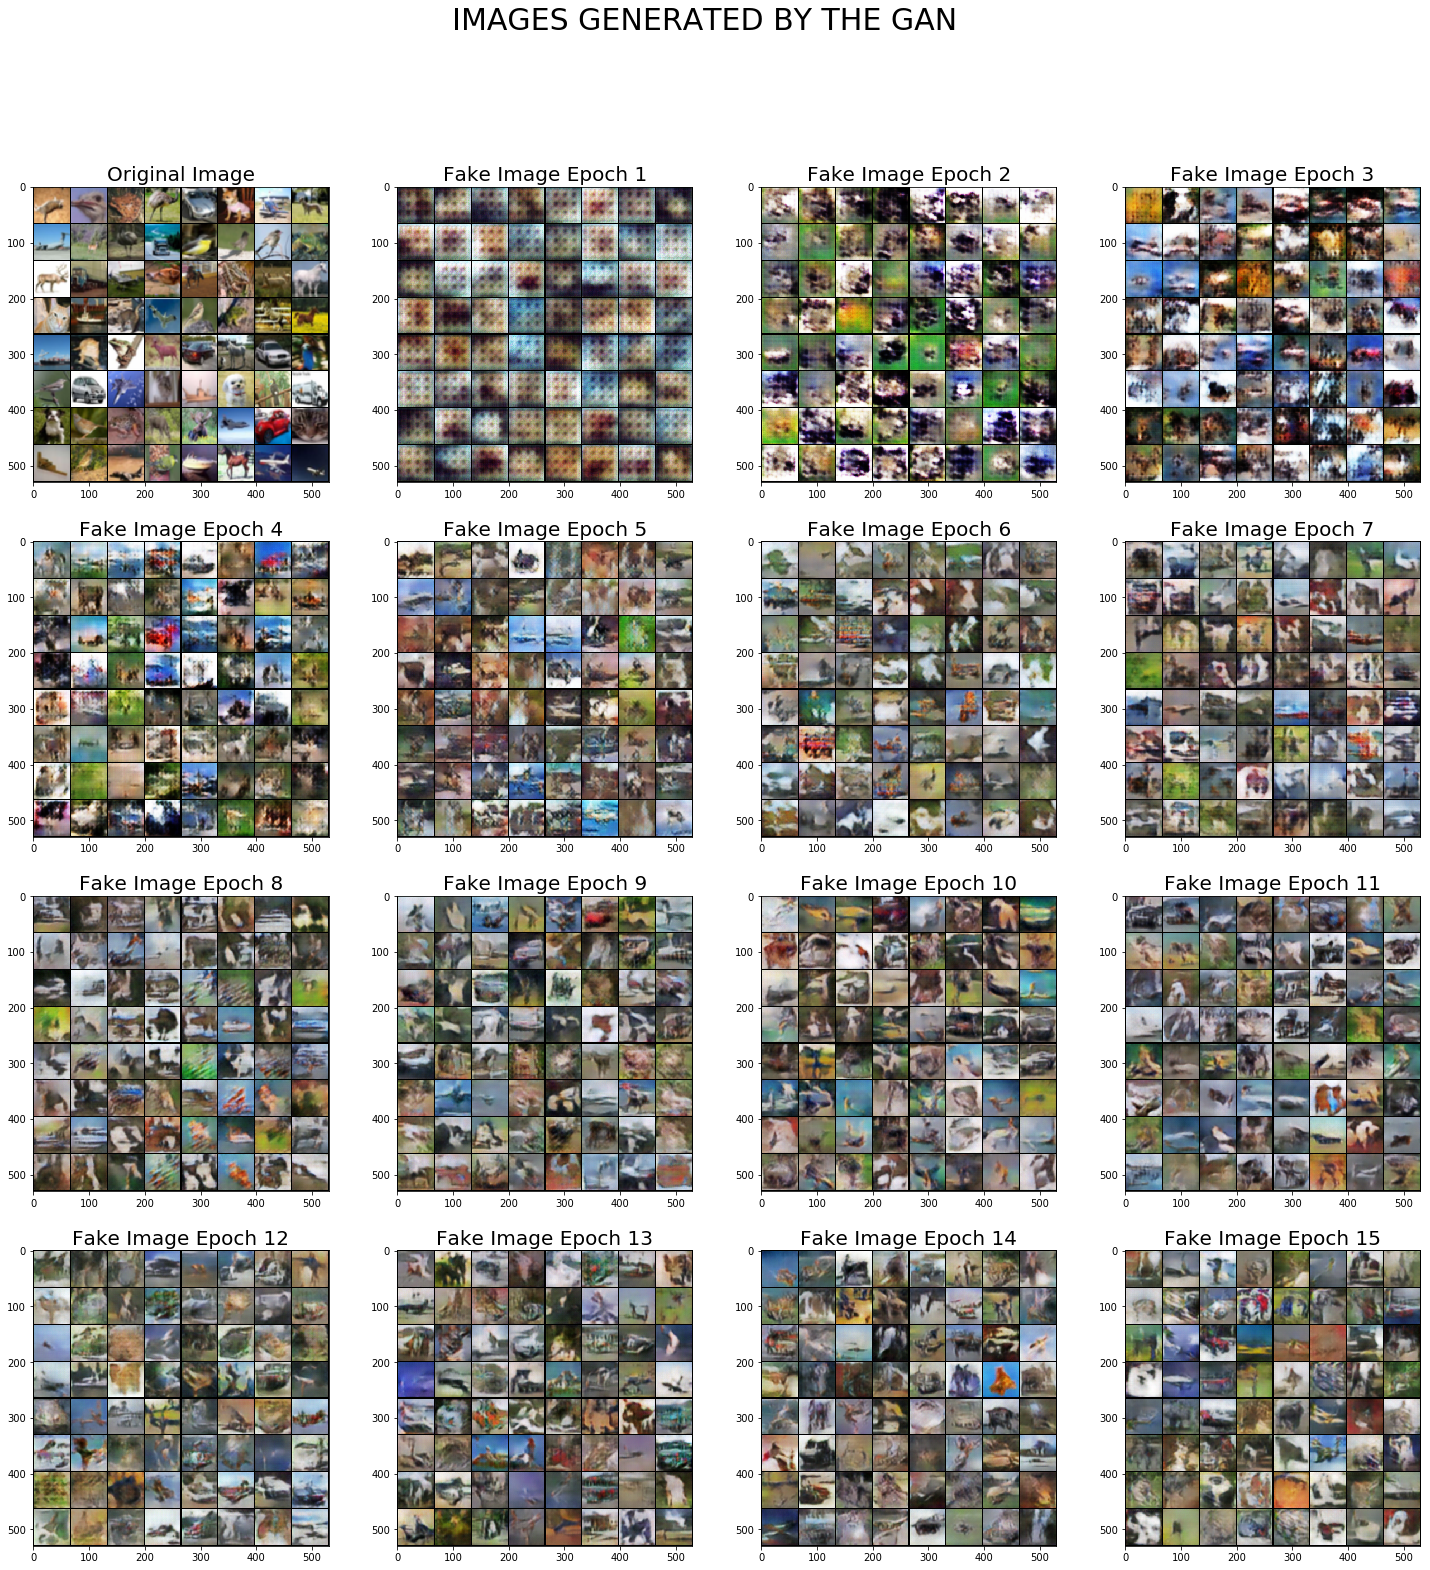

In [69]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, ax = plt.subplots(4, 4, figsize=(25,25))
fig.suptitle('IMAGES GENERATED BY THE GAN', fontsize=30)

index = 0
for i in range(4):
    for j in range(4):
        if(i == 0  and  j == 0):
            img=mpimg.imread('./results/real_samples.png')
            ax[i, j].imshow(img)
            ax[i, j].set_title("Original Image",fontsize=20)
        else:
            img=mpimg.imread('./results/fake_samples_epoch_0'+str(index).zfill(2)+'.png')
            ax[i, j].imshow(img)
            ax[i, j].set_title("Fake Image Epoch "+str((index+1)),fontsize=20)
            index += 1

plt.show()

# Conclusion

1. We have fake generated image by GANs after each epoch 

2. As You can see above after each epoch our fake generated image getting better and better.

3. If you run more epoch then you can get better image by previous image 

4. You can also get better accuracy by doing hyperparameter tuning